Test the general cluster model with mock Hyades data + DR2 errors.

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coords
# plotting
import matplotlib.pyplot as plt
from matplotlib import colors
import arviz as az
import seaborn as sns
from corner import corner
from getdist import plots, MCSamples
# project
import pystan
import gapipes as gp
import kinesis as kn
print(f"pystan v{pystan.__version__}")
np.random.seed(18324)

pystan v2.19.0.0


In [ ]:
# Utility functions
def stack_params(azfit, params):
    """
    
    params : list
        list of params
    """
    s = azfit.posterior.stack(sample=['chain', 'draw'])
    v = []
    for p in params:
        if s[p].ndim == 1:
            v.append(np.atleast_2d(s[p].values))
        else:
            v.append(s[p].values.reshape((-1, s[p].values.shape[-1])))
    return np.vstack(v).T

In [2]:
out_full = pd.read_csv("../data/hyades_full.csv")
df = out_full.loc[out_full['in_dr2'] == True]
print(f'{len(df)} rows')

515 rows


In [3]:
case = {}  # fit results will be saved
N=len(df)
truth_T0 = dict(
    b0=[17.7, 41.2, 13.3], v0=np.array([-6.32, 45.24, 5.30]), sigmav=0.3
)

## Simple case: T=0

In [4]:
%%time
fitter = kn.Fitter(include_T=False)
for iter_ in range(5):
    print(f'iteration {iter_}')
    name = f'T0_RV0_modelT0_{iter_}.fit'
    if os.path.exists(f'mock/{name}'):
        print('reading from disk')
        fit = kn.FitResult.from_pickle(f'mock/{name}')
    else:
        cl = kn.Cluster(**truth_T0).sample_at(df.g.icrs).observe(cov=df.g.make_cov())    
        data = cl.members.observed.copy()
        fit = fitter.fit(data, sample=False)
        print(f"v0, sigv = {fit['v0']}, {fit['sigv']:.4f}")
        print(f"diff from truth: {fit['v0']-truth_T0['v0']}, {fit['sigv']-truth_T0['sigmav']:.4f}")
        fit = fitter.fit(data, chains=4, iter=4000)
        fit.save(name)
    case[name] = fit

INFO:kinesis.models:Reading model from disk


iteration 0
reading from disk
iteration 1
reading from disk
iteration 2
reading from disk
iteration 3
reading from disk
iteration 4
reading from disk
CPU times: user 1.26 s, sys: 1.1 s, total: 2.36 s
Wall time: 2.38 s


In [5]:
az.summary(fit.azfit, var_names=['v0', 'sigv'])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
v0[0]  -6.418  0.042  -6.496   -6.340      0.001    0.001    2705.0  2705.0   
v0[1]  45.070  0.097  44.890   45.250      0.002    0.001    2669.0  2669.0   
v0[2]   5.274  0.034   5.212    5.340      0.001    0.000    2830.0  2830.0   
sigv    0.303  0.007   0.290    0.317      0.000    0.000    7279.0  7279.0   

       ess_bulk  ess_tail  r_hat  
v0[0]    2703.0    4161.0    1.0  
v0[1]    2667.0    3964.0    1.0  
v0[2]    2827.0    4179.0    1.0  
sigv     7250.0    6358.0    1.0

In [6]:
for iter_ in range(5):
    summary = az.summary(case[f'T0_RV0_modelT0_{iter_}.fit'].azfit, var_names=['v0','sigv'])
    t = np.array([truth_T0['v0'][0], truth_T0['v0'][1], truth_T0['v0'][2], truth_T0['sigmav']])
    dd = (summary.loc[:,'mean'].values - t)/summary.loc[:,'sd'].values
    print(f'{iter_} {dd}')

0 [ 1.15        1.42553191  1.15151515 -1.        ]
1 [-1.675      -2.05319149 -1.75757576 -1.85714286]
2 [ 0.05       -0.68817204  0.36363636 -0.57142857]
3 [-0.25       -1.09574468 -1.09090909  0.14285714]
4 [-2.33333333 -1.75257732 -0.76470588  0.42857143]


In [6]:
plt.style.use('smoh')
plt.rc("font", family="serif", size=12)
plt.rc("text", usetex=True)
plt.rc('figure', dpi=100)

In [16]:
az.summary(case['T0_RV0_modelT0_0.fit'].azfit, var_names=['v0'])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
v0[0]  -6.274  0.040  -6.351   -6.202      0.001    0.001    2693.0  2693.0   
v0[1]  45.374  0.094  45.195   45.548      0.002    0.001    2636.0  2636.0   
v0[2]   5.338  0.033   5.277    5.402      0.001    0.000    2739.0  2738.0   

       ess_bulk  ess_tail  r_hat  
v0[0]    2697.0    4461.0    1.0  
v0[1]    2643.0    4682.0    1.0  
v0[2]    2742.0    4423.0    1.0

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


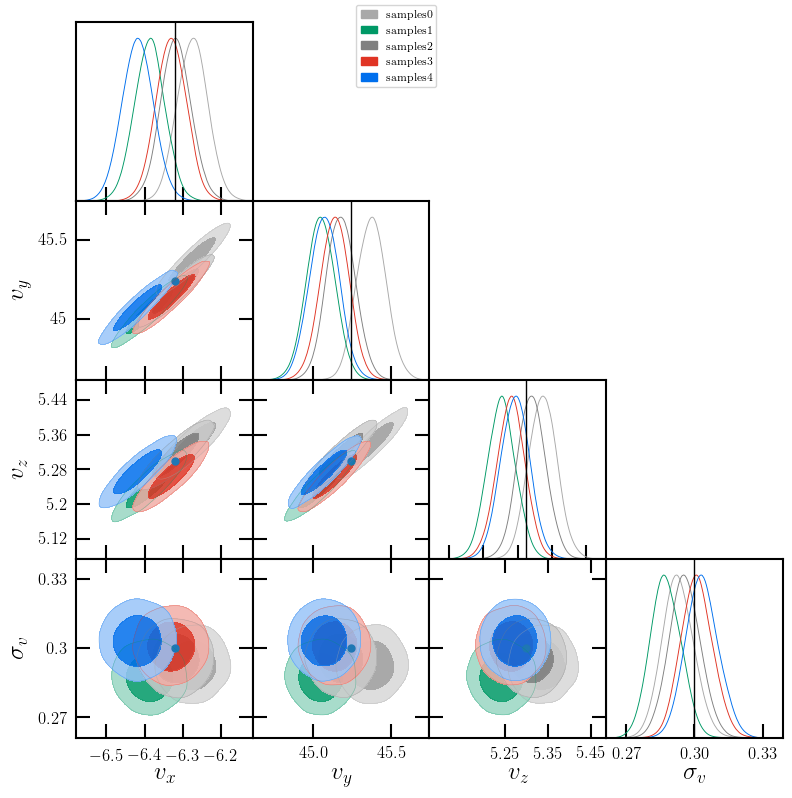

In [8]:
slist = []
for iter_ in range(5):
    fit = case[f"T0_RV0_modelT0_{iter_}.fit"]
    s = MCSamples(
        samples=np.hstack([fit.stanfit["v0"], fit.stanfit["sigv"][:, None]]),
        names=["vx", "vy", "vz", "sigv"],
        labels=["v_x", "v_y", "v_z", "\sigma_v"],
    )
    slist.append(s)

settings = plots.GetDistPlotSettings()
g = plots.getSubplotPlotter(settings=settings)
g.settings.axes_fontsize = 12
g.triangle_plot(slist, filled=True, contour_colors=["darkgray"])

# add 'truth' lines ad hoc
p = [truth_T0["v0"][0], truth_T0["v0"][1], truth_T0["v0"][2], truth_T0["sigmav"]]
for i, row in enumerate(g.subplots):
    for j, cax in enumerate(row):
        if cax:  # this is None if that axes is empty
            if i == j:
                cax.axvline(p[j], c="k", lw=1)
            #                 cax.axhline(p[i], c="k", lw=1)
            else:
                cax.scatter(p[j], p[i], s=25, color="tab:blue")

for cax in g.fig.axes:
    cax.yaxis.label.set_size(18)
    cax.xaxis.label.set_size(18)

g.fig.axes[-1].set_xticks([5.25, 5.35, 5.45]);

## Simple case: T=0 with partial RVs

In [17]:
%%time
fitter = kn.Fitter(include_T=False)

for iter_ in range(5):
    print(f"iteration {iter_}")
    name = f'T0_RVa_modelT0_{iter_}.fit'
    if os.path.exists(f'mock/{name}'):
        fit = kn.FitResult.from_pickle(f'mock/{name}')
    else:
        cl = kn.Cluster(**truth_T0).sample_at(df.g.icrs).observe(cov=df.g.make_cov())
        # attach simulated radial velocities only to stars with RV observed
        data = cl.members.observed.copy()
        irv = np.where(df["radial_velocity"].notnull())[0]
        data.loc[irv, "radial_velocity"] = np.random.normal(
            cl.members.truth["radial_velocity"].values[irv],
            scale=df["radial_velocity_error"].values[irv],
        )
        data.loc[irv, "radial_velocity_error"] = df.loc[irv, "radial_velocity_error"]

        fit = fitter.fit(data, sample=False)
        print(f"v0, sigv = {fit['v0']}, {fit['sigv']:.4f}")
        print(f"diff from truth: {fit['v0']-truth_T0['v0']}, {fit['sigv']-truth_T0['sigmav']:.4f}")
        fit = fitter.fit(data, chains=4, iter=4000)
        fit.save(f"mock/{name}")
    case[name] = fit

INFO:kinesis.models:Reading model from disk


iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
CPU times: user 1.76 s, sys: 1.14 s, total: 2.91 s
Wall time: 2.94 s


In [32]:
for iter_ in range(5):
    summary = az.summary(case[f'T0_RVa_modelT0_{iter_}.fit'].azfit, var_names=['v0','sigv'])
    t = np.array([truth_T0['v0'][0], truth_T0['v0'][1], truth_T0['v0'][2], truth_T0['sigmav']])
    dd = (summary.loc[:,'mean'].values - t)/summary.loc[:,'sd'].values
    print(f'{iter_} {dd}')

0 [-0.52631579 -0.63636364  0.47058824  0.57142857]
1 [0.73684211 0.96969697 0.58823529 1.14285714]
2 [-1.94444444 -1.46875    -0.94117647  0.42857143]
3 [ 0.88888889  0.1875      0.5625     -0.85714286]
4 [-0.16666667  0.          2.5625     -0.42857143]


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


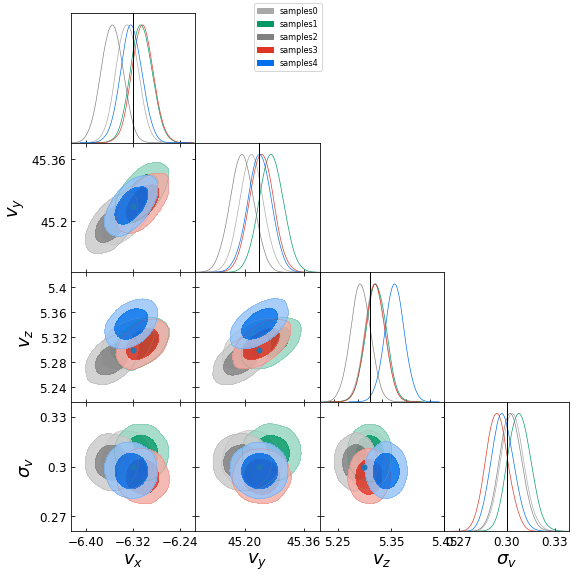

In [10]:
slist = []
for iter_ in range(5):
    fit = case[f"T0_RVa_modelT0_{iter_}.fit"]
    s = MCSamples(
        samples=np.hstack([fit.stanfit["v0"], fit.stanfit["sigv"][:, None]]),
        names=["vx", "vy", "vz", "sigv"],
        labels=["v_x", "v_y", "v_z", "\sigma_v"],
    )
    slist.append(s)

settings = plots.GetDistPlotSettings()
g = plots.getSubplotPlotter(settings=settings)
g.settings.axes_fontsize = 12
g.triangle_plot(slist, filled=True, contour_colors=["darkgray"])

# add 'truth' lines ad hoc
p = [truth_T0["v0"][0], truth_T0["v0"][1], truth_T0["v0"][2], truth_T0["sigmav"]]
for i, row in enumerate(g.subplots):
    for j, cax in enumerate(row):
        if cax:  # this is None if that axes is empty
            if i == j:
                cax.axvline(p[j], c="k", lw=1)
            #                 cax.axhline(p[i], c="k", lw=1)
            else:
                cax.scatter(p[j], p[i], s=25, color="tab:blue")

for cax in g.fig.axes:
    cax.yaxis.label.set_size(18)
    cax.xaxis.label.set_size(18)

g.fig.axes[-1].set_xticks([5.25, 5.35, 5.45])

Removed no burn in
Removed no burn in


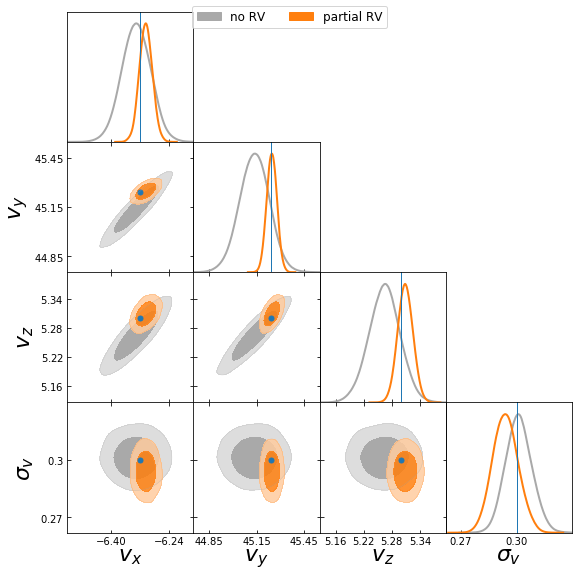

In [10]:
samples_list = []
for k in ['T0_RV0_modelT0_3.fit', 'T0_RVa_modelT0_3.fit']:
    fit = case[k]
    s = MCSamples(
        samples=np.hstack([fit.stanfit["v0"], fit.stanfit["sigv"][:, None]]),
        names=["vx", "vy", "vz", "sigv"],
        labels=["v_x", "v_y", "v_z", "\sigma_v"],
    )
    samples_list.append(s)

samples_list[0].label = "no RV"
samples_list[1].label = "partial RV"

# Triangle plot
g = plots.getSubplotPlotter()
g.triangle_plot(
    samples_list,
    contour_colors=["darkgray", "tab:orange"],
    contour_lws=[2,2], filled=True,
    legend_ncol=2,
)
g.settings.figure_legend_frame = False
g.settings.axes_fontsize = 14

g.fig.axes[1].lines[0].set_linewidth(2)

# add 'truth' lines ad hoc
p = [truth_T0["v0"][0], truth_T0["v0"][1], truth_T0["v0"][2], truth_T0["sigmav"]]
for i, row in enumerate(g.subplots):
    for j, cax in enumerate(row):
        if cax:  # this is None if that axes is empty
            if i == j:
                cax.axvline(p[j], lw=1, c="tab:blue")
            #                 cax.axhline(p[i], c="k", lw=1)
            else:
                cax.scatter(p[j], p[i], s=25, color="tab:blue")

for cax in g.fig.axes:
    cax.yaxis.label.set_size(22)
    cax.xaxis.label.set_size(22)

# g.fig.savefig("T0_RVcompare_modelT0_0.pdf")

## When T=0 data is modeled with T, no RV

could not get this to sample correctly

In [ ]:
%%time
fitter = kn.Fitter(include_T=True)

for iter_ in range(1):
    print(f"iteration {iter_}")
    cl = kn.Cluster(**truth_T0).sample_at(df.g.icrs).observe(cov=df.g.make_cov())

    # attach simulated radial velocities only to stars with RV observed
    data = cl.members.observed.copy()
    # have to give this when T is included in model
    data['radial_velocity'] = np.nan
    data['radial_velocity_error'] = np.nan

    fit = fitter.fit(data, sample=False, b0=truth_T0['b0'])
    print(f"v0, sigv = {fit['v0']}, {fit['sigv']:.4f}")
    print(f"diff from truth: {fit['v0']-truth_T0['v0']}, {fit['sigv']-truth_T0['sigmav']:.4f}")

    fit = fitter.fit(data, b0=truth_T0['b0'])

#     azfit = az.from_pystan(case['null_T1_rv0.stanfit'], **azkwargs)

INFO:kinesis.models:Reading model from disk
INFO:numexpr.utils:NumExpr defaulting to 4 threads.


iteration 0
v0, sigv = [-6.287595   45.32557672  5.32249328], 0.2811
diff from truth: [0.032405   0.08557672 0.02249328], -0.0189


## When T=0 data is modeled with T, 1 RV

In [18]:
%%time
fitter = kn.Fitter(include_T=True)

for iter_ in range(1):
    print(f"iteration {iter_}")
    name = f'T0_RV1_modelT1_{iter_}.fit'
    if os.path.exists(f'mock/{name}'):
        fit = kn.FitResult.from_pickle(f'mock/{name}')
    else:
        cl = kn.Cluster(**truth_T0).sample_at(df.g.icrs).observe(cov=df.g.make_cov())
        # one random star with radial velocity
        data = cl.members.observed.copy()
        # have to give this when T is included in model
        data['radial_velocity'] = np.nan
        data['radial_velocity_error'] = np.nan
        ilucky = np.random.randint(0, len(data))
        rv_error = .1
        data['radial_velocity'][ilucky] = np.random.normal(cl.members.truth['radial_velocity'][ilucky], rv_error)
        data['radial_velocity_error'][ilucky] = rv_error
        
        # do fitting
        fit = fitter.fit(data, sample=False, b0=truth_T0['b0'])
        print(f"v0, sigv = {fit['v0']}, {fit['sigv']:.4f}")
        print(f"diff from truth: {fit['v0']-truth_T0['v0']}, {fit['sigv']-truth_T0['sigmav']:.4f}")

        fit = fitter.fit(data, b0=truth_T0['b0'], chains=4, iter=4000)
        fit.save(f"mock/{name}")
    case[name] = fit

INFO:kinesis.models:Reading model from disk


iteration 0
CPU times: user 318 ms, sys: 265 ms, total: 583 ms
Wall time: 585 ms


Removed no burn in
Removed no burn in
Removed no burn in


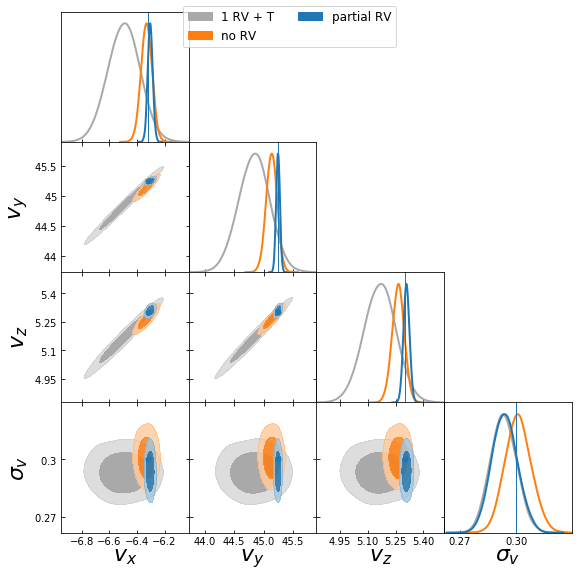

In [11]:
samples_list = []
for k in ['T0_RV1_modelT1_0.fit', 'T0_RV0_modelT0_3.fit', 'T0_RVa_modelT0_3.fit']:
    fit = case[k]
    s = MCSamples(
        samples=np.hstack([fit.stanfit["v0"], fit.stanfit["sigv"][:, None]]),
        names=["vx", "vy", "vz", "sigv"],
        labels=["v_x", "v_y", "v_z", "\sigma_v"],
    )
    samples_list.append(s)

samples_list[0].label = '1 RV + T'
samples_list[1].label = "no RV"
samples_list[2].label = "partial RV"


# Triangle plot
g = plots.getSubplotPlotter()
g.triangle_plot(
    samples_list,
    contour_colors=["darkgray", "tab:orange", 'tab:blue'],
    contour_lws=[2,2,2], filled=True,
    legend_ncol=2,
)
g.settings.figure_legend_frame = False
g.settings.axes_fontsize = 14

g.fig.axes[1].lines[0].set_linewidth(2)

# add 'truth' lines ad hoc
p = [truth_T0["v0"][0], truth_T0["v0"][1], truth_T0["v0"][2], truth_T0["sigmav"]]
for i, row in enumerate(g.subplots):
    for j, cax in enumerate(row):
        if cax:  # this is None if that axes is empty
            if i == j:
                cax.axvline(p[j], lw=1, c="tab:blue")
            #                 cax.axhline(p[i], c="k", lw=1)
            else:
                cax.scatter(p[j], p[i], s=25, color="tab:blue")

for cax in g.fig.axes:
    cax.yaxis.label.set_size(22)
    cax.xaxis.label.set_size(22)

# g.fig.savefig("T0_RVcompare_modelT0_0.pdf")

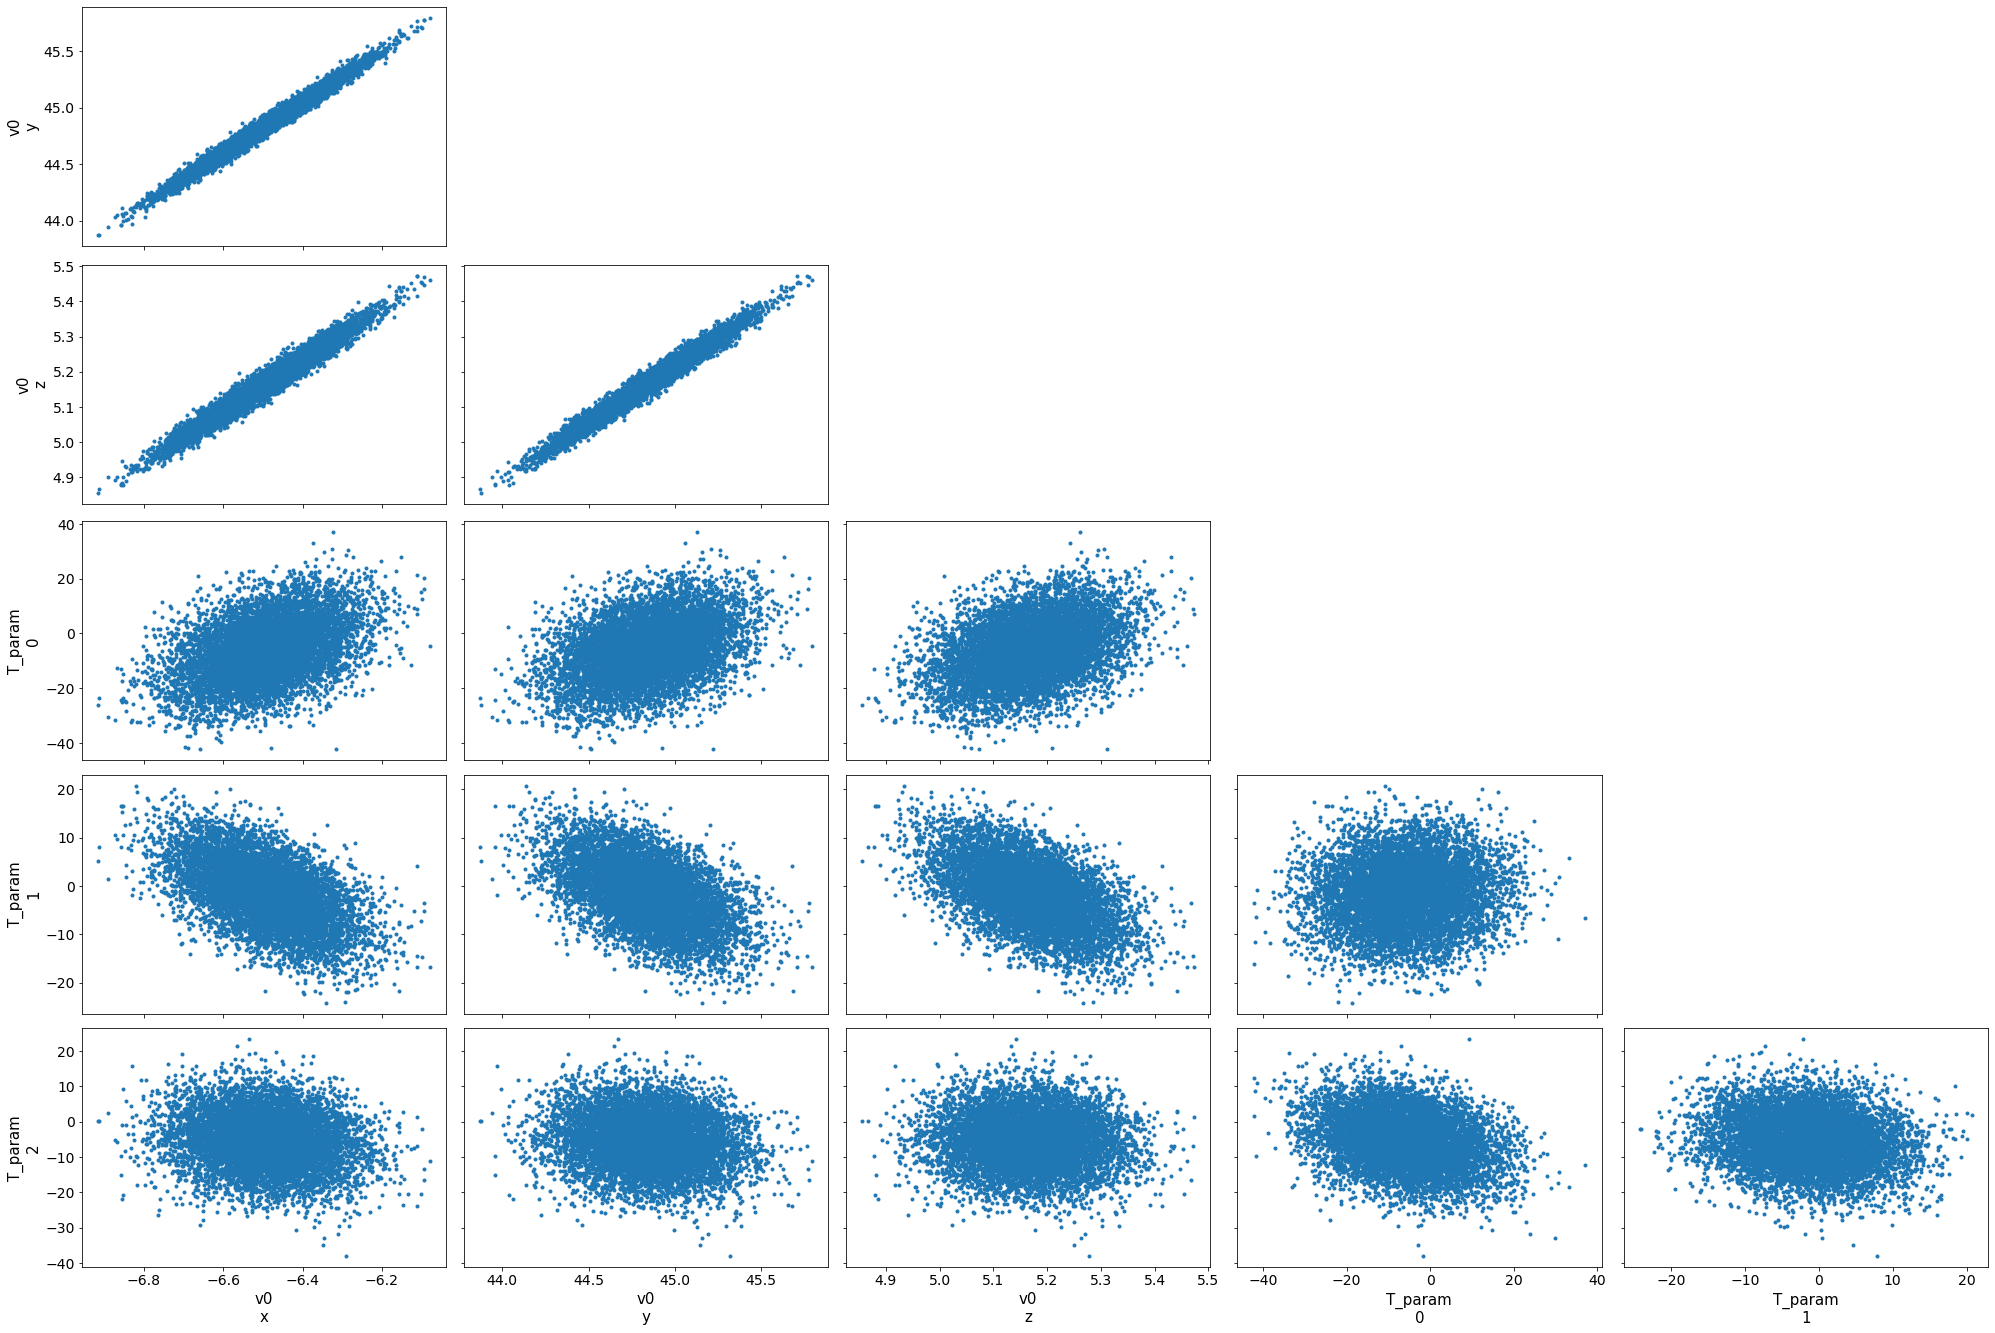

In [40]:
ax = az.plot_pair(
    fit.azfit, ["v0", "T_param"], coords={"T_param_dim_0": 0, "T_param_dim_1": [0,1,2]}
)

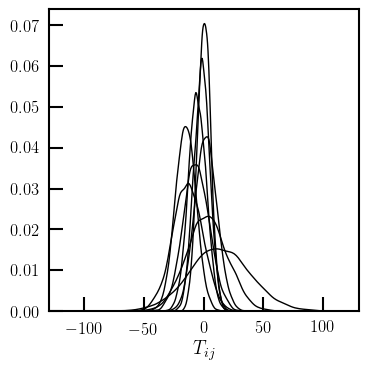

In [50]:
posterior_T = fit.azfit.posterior['T_param'].stack(sample=['chain','draw']).values
posterior_T_reshaped = posterior_T.reshape((9,8000))

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
for tij in posterior_T_reshaped:
    sns.distplot(tij, hist=False, color='k', kde_kws=dict(lw=1), ax=ax)
ax.set_xlabel(r"$T_{ij}$", size=14)
# ax.axvline(0, lw=1);
ax.set_xlim(-130,130);

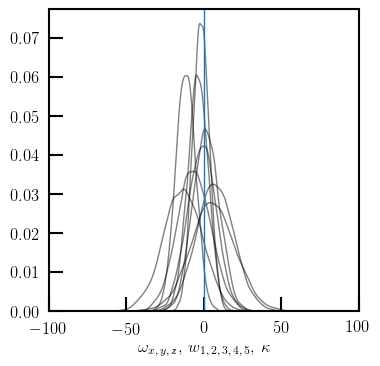

In [51]:
names = ["omegax", "omegay", "omegaz", "w1", "w2", "w3", "w4", "w5", "kappa"]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

for k,v in kn.decompose_T(fit.azfit.posterior.T_param).items():
    fit.azfit.posterior[k] = v
for n in names:
    sns.distplot(
        fit.azfit.posterior.stack(sample=["chain", "draw"])[n],
        hist=False,
        color="k",
        kde_kws=dict(alpha=0.5, lw=1),
        ax=ax,
    )
ax.set_xlabel(r"$\omega_{x,\,y,\,z},\,w_{1,\,2,\,3,\,4,\,5},\,\kappa$")
ax.axvline(0, lw=1);
ax.set_xlim(-100,100);

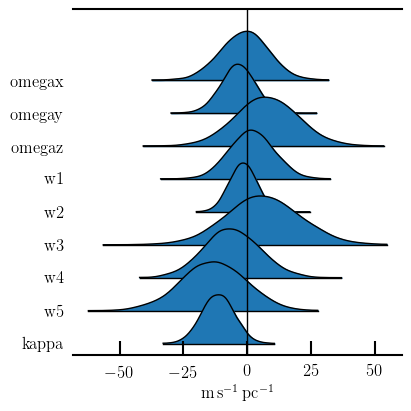

In [52]:
fig, ax = az.plot_forest(
    fit.azfit, kind="ridgeplot", var_names=names, combined=True, ridgeplot_overlap=2, figsize=(4, 4),
    linewidth=1,
)
ax[0].axvline(0, c='k', lw=1);
ax[0].set_xlabel(r"${\rm m}\,{\rm s}^{-1}\,{\rm pc}^{-1}$");

In [60]:
az.summary(azfit, var_names=names)

mean      sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
omegax  -1.571   9.649 -19.209   17.739      0.311    0.220     961.0   961.0   
omegay  -3.493   6.537 -15.545    8.999      0.229    0.162     815.0   815.0   
omegaz   7.343  11.571 -13.893   29.543      0.338    0.239    1170.0  1170.0   
w1       1.834   8.725 -14.733   18.043      0.248    0.175    1237.0  1237.0   
w2      -1.635   5.096 -11.220    7.724      0.119    0.084    1819.0  1819.0   
w3       5.753  13.901 -20.355   31.774      0.491    0.347     801.0   801.0   
w4      -6.349  10.907 -26.380   15.369      0.344    0.243    1006.0  1006.0   
w5     -13.767  12.299 -36.012    9.993      0.352    0.249    1222.0  1222.0   
kappa  -11.672   6.287 -23.400    0.086      0.170    0.120    1364.0  1364.0   

        ess_bulk  ess_tail  r_hat  
omegax     966.0    1261.0    1.0  
omegay     815.0    1464.0    1.0  
omegaz    1168.0    2024.0    1.0  
w1        1238.0    2021.0    1.0  
w2        1815.0    2630.0    1.0  
w3         807.0    1583.0    1.0  
w4        1012.0    1542.0    1.0  
w5        1225.0    1832.0    1.0  
kappa     1368.0    1941.0    1.0

In [170]:
import astropy.constants as c

In [171]:
((1*u.pc) * (u.km/u.s)**2 / c.G).to(u.solMass)

<Quantity 232.50854113 solMass>

* need to clean the data for anomalous sources
* coordinate transformation of T matrix to galactic can be more informative 
* need to do sampling of null mock data (T=0) to make sure T comes out 0
* need to fit mock data with wrong b0

In [9]:
(dr2hy['phot_g_mean_mag']<12).sum()

176

## When T=0 data is modeled with T, 156 RVs

In [19]:
%%time
fitter = kn.Fitter(include_T=True)

for iter_ in range(2):
    print(f"iteration {iter_}")
    name = f"T0_RVa_modelT1_{iter_}.fit"
    if os.path.exists(f'mock/{name}'):
        fit = kn.FitResult.from_pickle(f'mock/{name}')
    else:
        cl = kn.Cluster(**truth_T0).sample_at(df.g.icrs).observe(cov=df.g.make_cov())

        data = cl.members.observed.copy()
        # attach simulated radial velocities only to stars with RV observed
        data = cl.members.observed.copy()
        irv = np.where(df["radial_velocity"].notnull())[0]
        data.loc[irv, "radial_velocity"] = np.random.normal(
            cl.members.truth["radial_velocity"].values[irv],
            scale=df["radial_velocity_error"].values[irv],
        )
        data.loc[irv, "radial_velocity_error"] = df.loc[irv, "radial_velocity_error"]

        fit = fitter.fit(data, sample=False, b0=truth_T0['b0'])
        print(f"v0, sigv = {fit['v0']}, {fit['sigv']:.4f}")
        print(f"diff from truth: {fit['v0']-truth_T0['v0']}, {fit['sigv']-truth_T0['sigmav']:.4f}")

        fit = fitter.fit(data, b0=truth_T0['b0'],  chains=4, iter=4000)
        fit.save(f"mock/{name}")
    case[name] = fit

INFO:kinesis.models:Reading model from disk


iteration 0
iteration 1
CPU times: user 773 ms, sys: 520 ms, total: 1.29 s
Wall time: 1.31 s


In [28]:
from chainconsumer import ChainConsumer

CPU times: user 10.1 s, sys: 2.73 s, total: 12.9 s
Wall time: 8.68 s


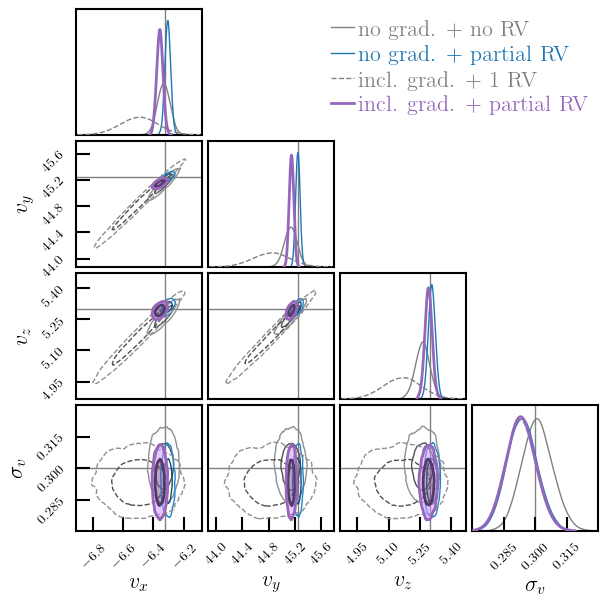

In [64]:
%%time
c = ChainConsumer()
data1 = stack_params(case['T0_RV0_modelT0_3.fit'].azfit, ['v0','sigv'])
data2 = stack_params(case['T0_RVa_modelT0_3.fit'].azfit, ['v0','sigv'])
data3 = stack_params(case['T0_RV1_modelT1_0.fit'].azfit, ['v0','sigv'])
data4 = stack_params(case['T0_RVa_modelT1_0.fit'].azfit, ['v0','sigv'])
p_true = list(truth_T0['v0']) + [truth_T0['sigmav']]

c.add_chain(data1, kde=True, parameters=["$v_x$", "$v_y$", "$v_z$", "$\sigma_v$"],  name='no grad. + no RV', color=colors.to_hex('gray'))
c.add_chain(data2, kde=True, name='no grad. + partial RV', color=colors.to_hex('tab:blue'))
c.add_chain(data3, kde=True, zorder=5, name='incl. grad. + 1 RV', color=colors.to_hex('gray'), linestyle='dashed')
c.add_chain(data4, kde=True, zorder=10, name='incl. grad. + partial RV', shade=True, color=colors.to_hex('tab:purple'), linewidth=2)
c.configure(diagonal_tick_labels=True, tick_font_size=10, label_font_size=16, legend_artists=True)
c.configure_truth(ls='solid', color='gray', zorder=-10)
fig = c.plotter.plot(truth=p_true)
fig.subplots_adjust(bottom=0.12, left=0.12, right=0.99, top=0.99)
fig.savefig("mock_posterior_v0_sigv_allcases.pdf");

In [22]:
# NOTE: Code to compare fits for v0 and sigv with getdist
#       It takes too long to work with.
# samples_list = []
# for k in ['T0_RV0_modelT0_3.fit', 'T0_RVa_modelT0_3.fit', 'T0_RV1_modelT1_0.fit', 'T0_RVa_modelT1_0.fit']:
#     fit = case[k]
#     s = MCSamples(
#         samples=np.hstack([fit.stanfit["v0"], fit.stanfit["sigv"][:, None]])[::10],
#         names=["vx", "vy", "vz", "sigv"],
#         labels=["v_x", "v_y", "v_z", "\sigma_v"],
#     )
#     samples_list.append(s)

# samples_list[0].label = "no RV"
# samples_list[1].label = "partial RV"
# samples_list[2].label = '1 RV + T'
# samples_list[3].label = 'partial RV + T'

# %%time
# # Triangle plot
# g = plots.getSubplotPlotter()
# g.triangle_plot(
#     samples_list,
#     contour_colors=["darkgray", "tab:orange", 'tab:blue', 'tab:red'],
#     contour_lws=[1,1,1,1],
#     legend_ncol=2,
# )
# g.settings.figure_legend_frame = False
# g.settings.axes_fontsize = 14
# g.fig.axes[1].lines[0].set_linewidth(2)

# # add 'truth' lines ad hoc
# p = [truth_T0["v0"][0], truth_T0["v0"][1], truth_T0["v0"][2], truth_T0["sigmav"]]
# for i, row in enumerate(g.subplots):
#     for j, cax in enumerate(row):
#         if cax:  # this is None if that axes is empty
#             if i == j:
#                 cax.axvline(p[j], lw=1, c="tab:blue")
#             #                 cax.axhline(p[i], c="k", lw=1)
#             else:
#                 cax.scatter(p[j], p[i], s=25, color="tab:blue")

# for cax in g.fig.axes:
#     cax.yaxis.label.set_size(22)
#     cax.xaxis.label.set_size(22)

In [96]:
from functools import partial

/data/vault/soh/projects/opensource/arviz/arviz/plots/kdeplot.py:413: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(cov ** 0.5)


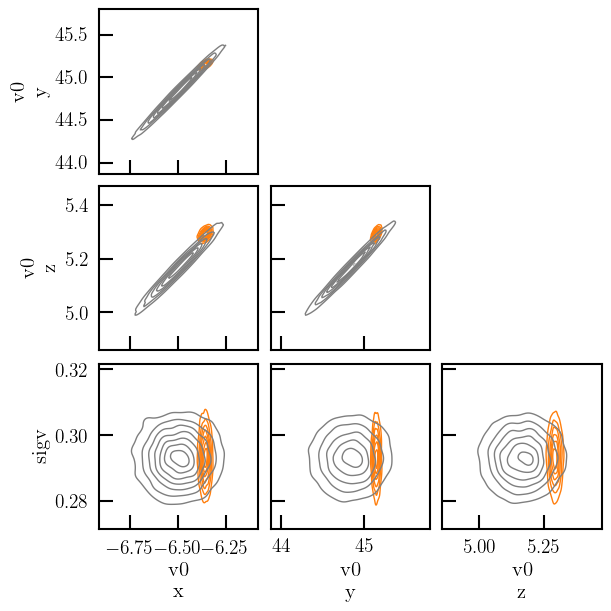

In [111]:
plot_pair_v0_sigv = partial(az.plot_pair, kind='kde',
                            var_names=['v0', 'sigv'], plot_kwargs=dict(contourf_kwargs={'alpha':0}),
                            fill_last=False)
axgrid = plot_pair_v0_sigv(azfit1, plot_kwargs=dict(contour_kwargs={'colors':'C1', 'linewidths':1}, contourf_kwargs={'alpha':0}), figsize=(6,6))
axgrid = plot_pair_v0_sigv(azfit, plot_kwargs=dict(contour_kwargs={'colors':'C7', 'linewidths':1}, contourf_kwargs={'alpha':0}), ax=axgrid)

In [35]:
for iter_ in range(2):
    summary = az.summary(case[f'T0_RVa_modelT1_{iter_}.fit'].azfit, var_names=['v0','sigv'])
    t = np.array([truth_T0['v0'][0], truth_T0['v0'][1], truth_T0['v0'][2], truth_T0['sigmav']])
    dd = (summary.loc[:,'mean'].values - t)/summary.loc[:,'sd'].values
    print(f'{iter_} {dd}')

0 [-1.85       -2.78787879 -0.41176471 -1.        ]
1 [-1.95238095 -0.44117647 -0.72222222  1.14285714]


Text(0.5, 0, '${\\rm m}\\,{\\rm s}^{-1}\\,{\\rm pc}^{-1}$')

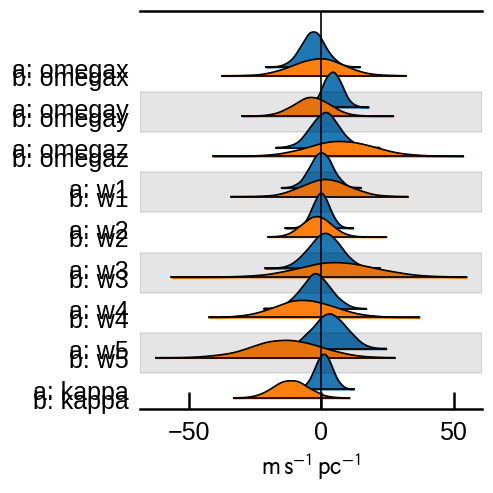

In [30]:
azfit = case['T0_RV1_modelT1_0.fit'].azfit
azfit1 = case['T0_RVa_modelT1_0.fit'].azfit

for k,v in kn.decompose_T(azfit1.posterior.T_param).items():
    azfit1.posterior[k] = v
for k,v in kn.decompose_T(azfit.posterior.T_param).items():
    azfit.posterior[k] = v

fig, ax = az.plot_forest(
    [azfit1, azfit],
    kind="ridgeplot",
    var_names=names,
    combined=True,
    ridgeplot_overlap=3,
    figsize=(4, 4),
    linewidth=1,
    model_names=["a", "b"],
)
ax[0].axvline(0, c="k", lw=1)
ax[0].set_xlabel(r"${\rm m}\,{\rm s}^{-1}\,{\rm pc}^{-1}$")

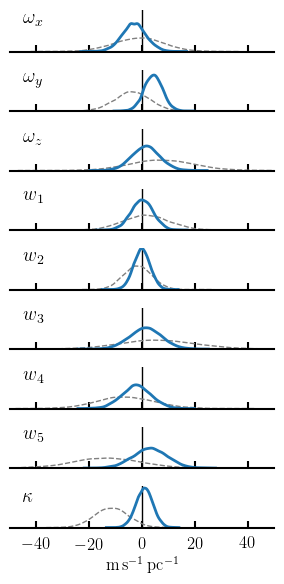

In [110]:
azfit = case['T0_RV1_modelT1_0.fit'].azfit
azfit1 = case['T0_RVa_modelT1_0.fit'].azfit
labels = [
    "$\omega_x$",
    "$\omega_y$",
    "$\omega_z$",
    "$w_1$",
    "$w_2$",
    "$w_3$",
    "$w_4$",
    "$w_5$",
    "$\kappa$",
]
names = ["omegax", "omegay", "omegaz", "w1", "w2", "w3", "w4", "w5", "kappa"]
d1 = azfit.posterior.stack(sample=['chain', 'draw'])[names].to_dataframe().reset_index(drop=True)
d1['group'] = 0
d2 = azfit1.posterior.stack(sample=['chain', 'draw'])[names].to_dataframe().reset_index(drop=True)
d2['group'] = 1

d = pd.concat([d1,d2])

fig, ax = plt.subplots(9, 1, figsize=(3, 6), sharex=True)
for label, name, cax in zip(labels, names, ax.ravel()):
    sns.kdeplot(d1[name], ax=cax, legend=False, lw=1, ls='dashed', color='gray')
    sns.kdeplot(d2[name], ax=cax, legend=False, lw=2, color='tab:blue');
    
    cax.spines['right'].set_visible(False)
    cax.spines['left'].set_visible(False)
    cax.spines['top'].set_visible(False)
#     cax.spines['bottom'].set_visible(False)
    cax.set_facecolor((1,1,1,0))
    cax.get_yaxis().set_visible(False)
    cax.axvline(0, lw=1, c='k', zorder=-1)
#     cax.get_xaxis().set_visible(False)

    cax.text(0.05,0.95, label, transform=cax.transAxes, va='top', size=14)
    cax.tick_params(length=5)
    cax.set_ylim(0, 0.13)


cax.get_xaxis().set_visible(True)
cax.set_xticks([-40,-20,0,20,40])
cax.set_xlim([-50,50])
fig.subplots_adjust(hspace=0)
cax.set_xlabel(r"${\rm m}\,{\rm s}^{-1}\,{\rm pc}^{-1}$");
fig.tight_layout()
fig.savefig("mock_posterior_decomposed_T_compare.pdf")

In [143]:
summary1 = az.summary(case['T0_RV0_modelT0_3.fit'].azfit, var_names=['v0','sigv']).T.assign(**{n:np.NaN for n in names})
summary2 = az.summary(case['T0_RVa_modelT0_3.fit'].azfit, var_names=['v0','sigv']).T.assign(**{n:np.NaN for n in names})
summary3 = az.summary(case['T0_RV1_modelT1_0.fit'].azfit, var_names=['v0','sigv']+names).T
summary4 = az.summary(case['T0_RVa_modelT1_0.fit'].azfit, var_names=['v0','sigv']+names).T

for s, fn in zip([summary1,summary2,summary3,summary4], ['nograd_noRV.tex', 'nograd_partialRV.tex', 'inclgrad_1RV.tex','inclgrad_partialRV.tex']):
    print('\n'.join(s.loc[['mean','sd','hpd_3%', 'hpd_97%'],:].to_latex(index=True,header=False,na_rep='').splitlines()[2:-2]))

mean    & -6.330 &  45.137 &  5.264 &  0.301 & {} & {} & {} & {} & {} & {} & {} & {} & {} \\
sd      &  0.040 &   0.094 &  0.033 &  0.007 & {} & {} & {} & {} & {} & {} & {} & {} & {} \\
hpd\_3\%  & -6.408 &  44.964 &  5.202 &  0.288 & {} & {} & {} & {} & {} & {} & {} & {} & {} \\
hpd\_97\% & -6.258 &  45.316 &  5.327 &  0.314 & {} & {} & {} & {} & {} & {} & {} & {} & {} \\
mean    & -6.304 &  45.246 &  5.309 &  0.294 & {} & {} & {} & {} & {} & {} & {} & {} & {} \\
sd      &  0.018 &   0.032 &  0.016 &  0.007 & {} & {} & {} & {} & {} & {} & {} & {} & {} \\
hpd\_3\%  & -6.337 &  45.188 &  5.277 &  0.281 & {} & {} & {} & {} & {} & {} & {} & {} & {} \\
hpd\_97\% & -6.269 &  45.309 &  5.339 &  0.307 & {} & {} & {} & {} & {} & {} & {} & {} & {} \\
mean    & -6.494 &  44.839 &  5.166 &  0.293 &  -1.210 &  -3.670 &   7.505 &   1.617 &  -1.674 &   6.008 &  -6.088 & -13.530 & -11.568 \\
sd      &  0.118 &   0.268 &  0.087 &  0.007 &   9.279 &   6.544 &  12.024 &   8.549 &   5.236 &  14.362 &  10

In [141]:
print('\n'.join(summary1.loc[['mean','sd','hpd_3%', 'hpd_97%'],:].to_latex(index=True,header=False,na_rep='').splitlines()[2:-2]))

mean    & -6.330 &  45.137 &  5.264 &  0.301 & {} & {} & {} & {} & {} & {} & {} & {} & {} \\
sd      &  0.040 &   0.094 &  0.033 &  0.007 & {} & {} & {} & {} & {} & {} & {} & {} & {} \\
hpd\_3\%  & -6.408 &  44.964 &  5.202 &  0.288 & {} & {} & {} & {} & {} & {} & {} & {} & {} \\
hpd\_97\% & -6.258 &  45.316 &  5.327 &  0.314 & {} & {} & {} & {} & {} & {} & {} & {} & {} \\


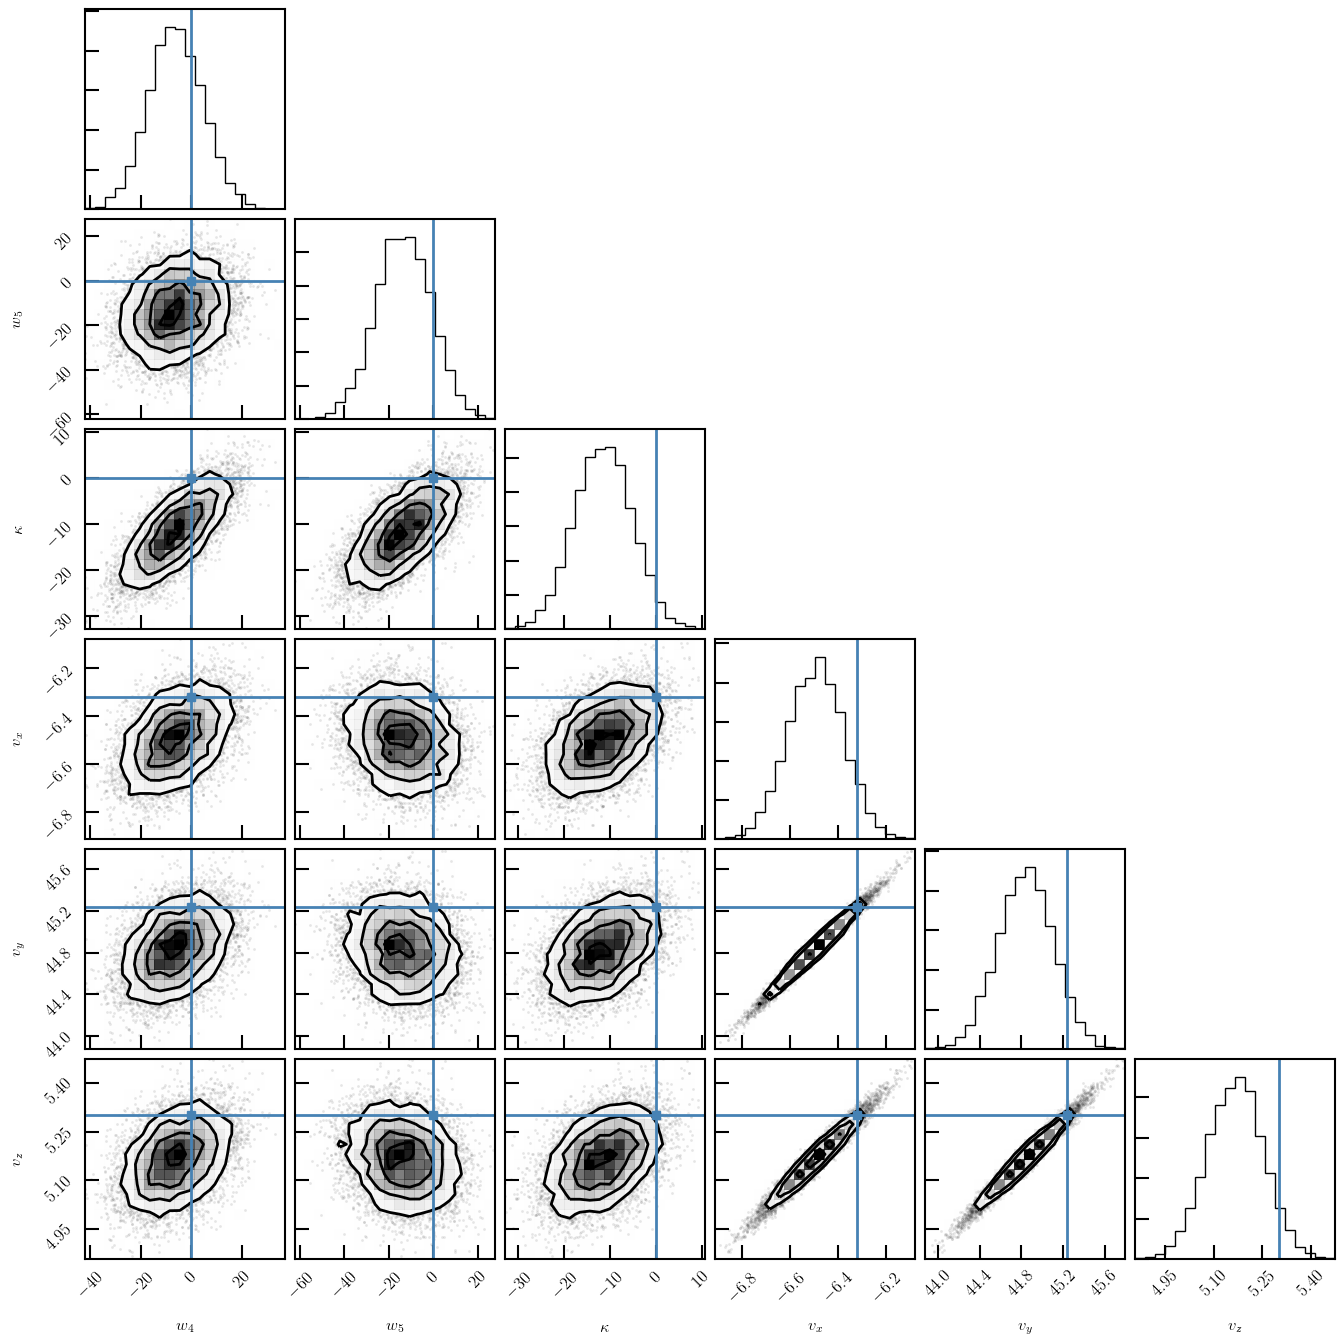

In [82]:
truths = [0, 0, 0] + list(truth_T0['v0'])
xs = stack_params(azfit, ['w4','w5','kappa','v0'])
corner(xs, truths=truths, labels=['$w_4$', '$w_5$', '$\kappa$', '$v_x$', '$v_y$', '$v_z$']);

## When T!=0 data is modeled with T, 156 RVs

In [84]:
truth_T1 = {
    "b0": [17.7, 41.2, 13.3],
    "v0": np.array([-6.32, 45.24, 5.3]),
    "sigmav": 0.3,
    "omegas": (40, 40, 40),
}

In [42]:
%%time
fitter = kn.Fitter(include_T=True)

for iter_ in range(1):
    print(f"iteration {iter_}")
    name = f"T1_RVa_modelT1_{iter_}.fit"
    if os.path.exists(f'mock/{name}'):
        fit = kn.FitResult.from_pickle(f'mock/{name}')
    else:
        cl = kn.Cluster(**truth_T1).sample_at(df.g.icrs).observe(cov=df.g.make_cov())

        data = cl.members.observed.copy()
        # attach simulated radial velocities only to stars with RV observed
        data = cl.members.observed.copy()
        irv = np.where(df["radial_velocity"].notnull())[0]
        data.loc[irv, "radial_velocity"] = np.random.normal(
            cl.members.truth["radial_velocity"].values[irv],
            scale=df["radial_velocity_error"].values[irv],
        )
        data.loc[irv, "radial_velocity_error"] = df.loc[irv, "radial_velocity_error"]

        fit = fitter.fit(data, sample=False, b0=truth_T0['b0'])
        print(f"v0, sigv = {fit['v0']}, {fit['sigv']:.4f}")
        print(f"diff from truth: {fit['v0']-truth_T0['v0']}, {fit['sigv']-truth_T0['sigmav']:.4f}")

        fit = fitter.fit(data, b0=truth_T0['b0'],  chains=4, iter=4000)
        fit.save(f"mock/{name}")
    case[name] = fit

INFO:kinesis.models:Reading model from disk


iteration 0
v0, sigv = [-6.32289469 45.21798331  5.29414227], 0.2917
diff from truth: [-0.00289469 -0.02201669 -0.00585773], -0.0083
CPU times: user 1min 31s, sys: 13.5 s, total: 1min 44s
Wall time: 19min 46s


In [44]:
for iter_ in range(1):
    summary = az.summary(case[f'T1_RVa_modelT1_{iter_}.fit'].azfit, var_names=['v0','sigv'])
    t = np.array([truth_T0['v0'][0], truth_T0['v0'][1], truth_T0['v0'][2], truth_T0['sigmav']])
    dd = (summary.loc[:,'mean'].values - t)/summary.loc[:,'sd'].values
    print(f'{iter_} {dd}')

0 [-0.05       -0.57142857 -0.47058824  0.42857143]


In [47]:
az.summary(case[f'T1_RVa_modelT1_0.fit'].azfit, var_names=['v0','sigv','T_param'])

mean      sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
v0[0]         -6.321   0.020  -6.360   -6.282      0.000    0.000    7699.0   
v0[1]         45.220   0.035  45.154   45.285      0.000    0.000    7472.0   
v0[2]          5.292   0.017   5.259    5.324      0.000    0.000    8392.0   
sigv           0.303   0.007   0.290    0.317      0.000    0.000   11553.0   
T_param[0,0]   4.932   5.603  -5.916   15.135      0.072    0.051    5986.0   
T_param[0,1] -42.246   3.616 -48.750  -35.263      0.048    0.034    5629.0   
T_param[0,2]  43.939   4.491  35.780   52.501      0.056    0.039    6470.0   
T_param[1,0]  40.787  10.675  21.658   61.617      0.143    0.101    5597.0   
T_param[1,1]  -9.319   6.538 -20.918    3.784      0.089    0.064    5403.0   
T_param[1,2] -46.103   8.240 -60.974  -29.798      0.108    0.076    5826.0   
T_param[2,0] -37.057   5.192 -46.823  -27.162      0.068    0.048    5915.0   
T_param[2,1]  37.203   3.192  30.966   42.934      0.041    0.029    5956.0   
T_param[2,2]  -2.264   4.066  -9.933    5.359      0.050    0.037    6550.0   

               ess_sd  ess_bulk  ess_tail  r_hat  
v0[0]          7699.0    7697.0    6212.0    1.0  
v0[1]          7472.0    7457.0    6318.0    1.0  
v0[2]          8392.0    8390.0    6202.0    1.0  
sigv          11512.0   11598.0    6191.0    1.0  
T_param[0,0]   5986.0    5970.0    6622.0    1.0  
T_param[0,1]   5604.0    5617.0    6174.0    1.0  
T_param[0,2]   6470.0    6472.0    6282.0    1.0  
T_param[1,0]   5597.0    5600.0    6356.0    1.0  
T_param[1,1]   5278.0    5408.0    6304.0    1.0  
T_param[1,2]   5826.0    5827.0    6010.0    1.0  
T_param[2,0]   5842.0    5906.0    6390.0    1.0  
T_param[2,1]   5956.0    5962.0    6079.0    1.0  
T_param[2,2]   5956.0    6548.0    6400.0    1.0

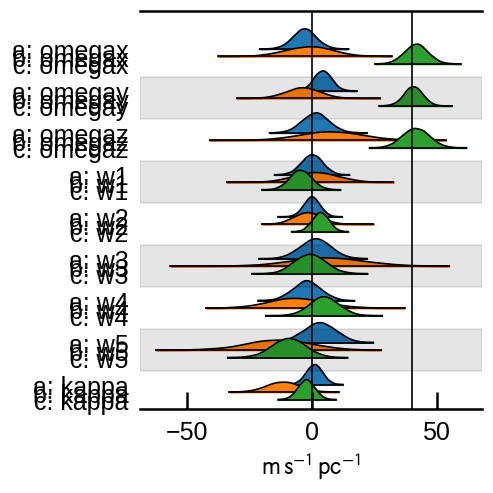

In [51]:
azfit = case['T0_RV1_modelT1_0.fit'].azfit
azfit1 = case['T0_RVa_modelT1_0.fit'].azfit
azfit2 = case['T1_RVa_modelT1_0.fit'].azfit

for k,v in kn.decompose_T(azfit1.posterior.T_param).items():
    azfit1.posterior[k] = v
for k,v in kn.decompose_T(azfit.posterior.T_param).items():
    azfit.posterior[k] = v
for k,v in kn.decompose_T(azfit2.posterior.T_param).items():
    azfit2.posterior[k] = v

fig, ax = az.plot_forest(
    [azfit1, azfit, azfit2],
    kind="ridgeplot",
    var_names=names,
    combined=True,
    ridgeplot_overlap=3,
    figsize=(4, 4),
    linewidth=1,
    model_names=["a", "b", "c"],
)
ax[0].axvline(0, c="k", lw=1)
ax[0].axvline(40, c="k", lw=1)
ax[0].set_xlabel(r"${\rm m}\,{\rm s}^{-1}\,{\rm pc}^{-1}$");

In [53]:
az.summary(azfit2, var_names=['omegax','omegay','omegaz'])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
omegax  41.653  4.598  33.136   50.462      0.065    0.046    5016.0  5016.0   
omegay  40.498  3.621  33.772   47.410      0.051    0.036    4946.0  4946.0   
omegaz  41.516  5.246  31.572   51.286      0.061    0.043    7450.0  7450.0   

        ess_bulk  ess_tail  r_hat  
omegax    5014.0    5569.0    1.0  
omegay    4950.0    5843.0    1.0  
omegaz    7449.0    6747.0    1.0

## Eigenvalue decomposition of sym(T)

In [229]:
import astropy.coordinates as coord

In [251]:
stanfit1 = case['T0_RVa_modelT1_0.stanfit']

In [265]:
# T_galactic = kn.rotate_T_to_galactic(stanfit["T_param"])
T_galactic = stanfit1["T_param"]
T_sym = (T_galactic + np.transpose(T_galactic, (0, 2, 1))) / 2.
T_antisym = (T_galactic - np.transpose(T_galactic, (0, 2, 1))) / 2.

In [266]:
# math check
assert (
    (T_antisym[:, 2, 1] == kn.decompose_T(T_galactic)["omegax"]).all(),
    (T_antisym[:, 0, 2] == kn.decompose_T(T_galactic)["omegay"]).all(),
    (T_antisym[:, 1, 0] == kn.decompose_T(T_galactic)["omegaz"]).all(),
) == (True, True, True)

In [267]:
# decompose and sort by eigenvalues
w, v = np.linalg.eig(T_sym)

i_wsort = np.argsort(w, axis=1)
# my numpy-fu running out...
sorted_v = np.stack([v[j][:,i] for j, i in enumerate(i_wsort)])
sorted_w = np.sort(w, axis=1)

# verify math
assert np.allclose(sorted_w.mean(axis=1), kn.decompose_T(T_galactic)["kappa"]) == True

In [268]:
# sorted_v[:,:,0] *= np.sign(sorted_v[:,2,0])[:,None]
# sorted_v[:,:,1] *= np.sign(sorted_v[:,2,1])[:,None]
# sorted_v[:,:,2] *= np.sign(sorted_v[:,2,2])[:,None]

 -10.617 +-    4.144 (   2.562)-0.00531, -0.13186,  0.05558
   0.839 +-    4.106 (   0.204)-0.09800, -0.02571,  0.46095
  13.132 +-    6.126 (   2.144)-0.09430, -0.01430,  0.19646


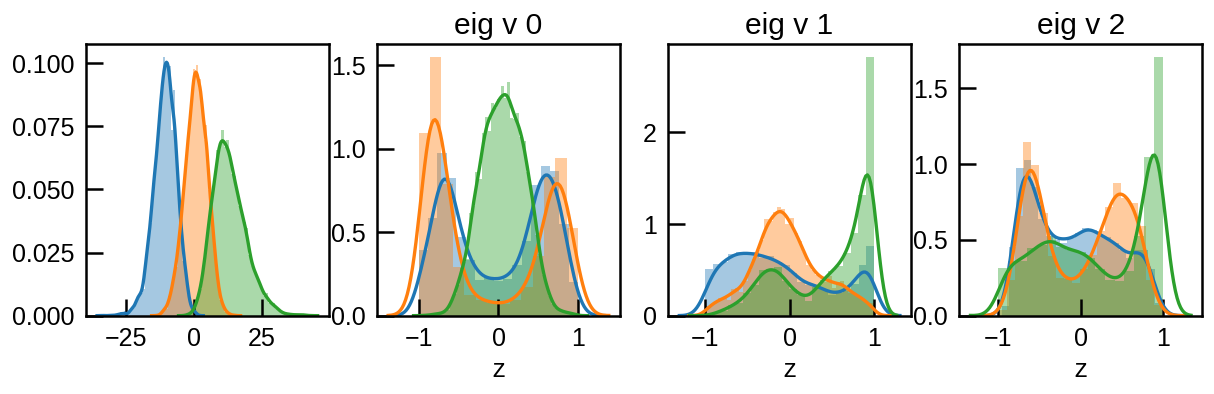

In [269]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
sns.distplot(sorted_w.T[0], ax=ax[0])
sns.distplot(sorted_w.T[1], ax=ax[0])
sns.distplot(sorted_w.T[2], ax=ax[0]);

for i in range(3):
    vd = pd.DataFrame(sorted_v[:,:,i], columns=['x','y','z'])
    for col in vd:
        sns.distplot(vd[col], ax=ax[i+1])#, legend=False)
    ax[i+1].set_title(f"eig v {i}")

for i, cw in enumerate(sorted_w.T):
    print(f"{np.mean(cw):8.3f} +- {np.std(cw):8.3f} ({np.abs(np.mean(cw)/np.std(cw)):8.3f})", end='')
    print(f"{np.mean(sorted_v[:,0,i]):-8.5f}, {np.mean(sorted_v[:,1,i]):-8.5f}, {np.mean(sorted_v[:,2,i]):-8.5f}")

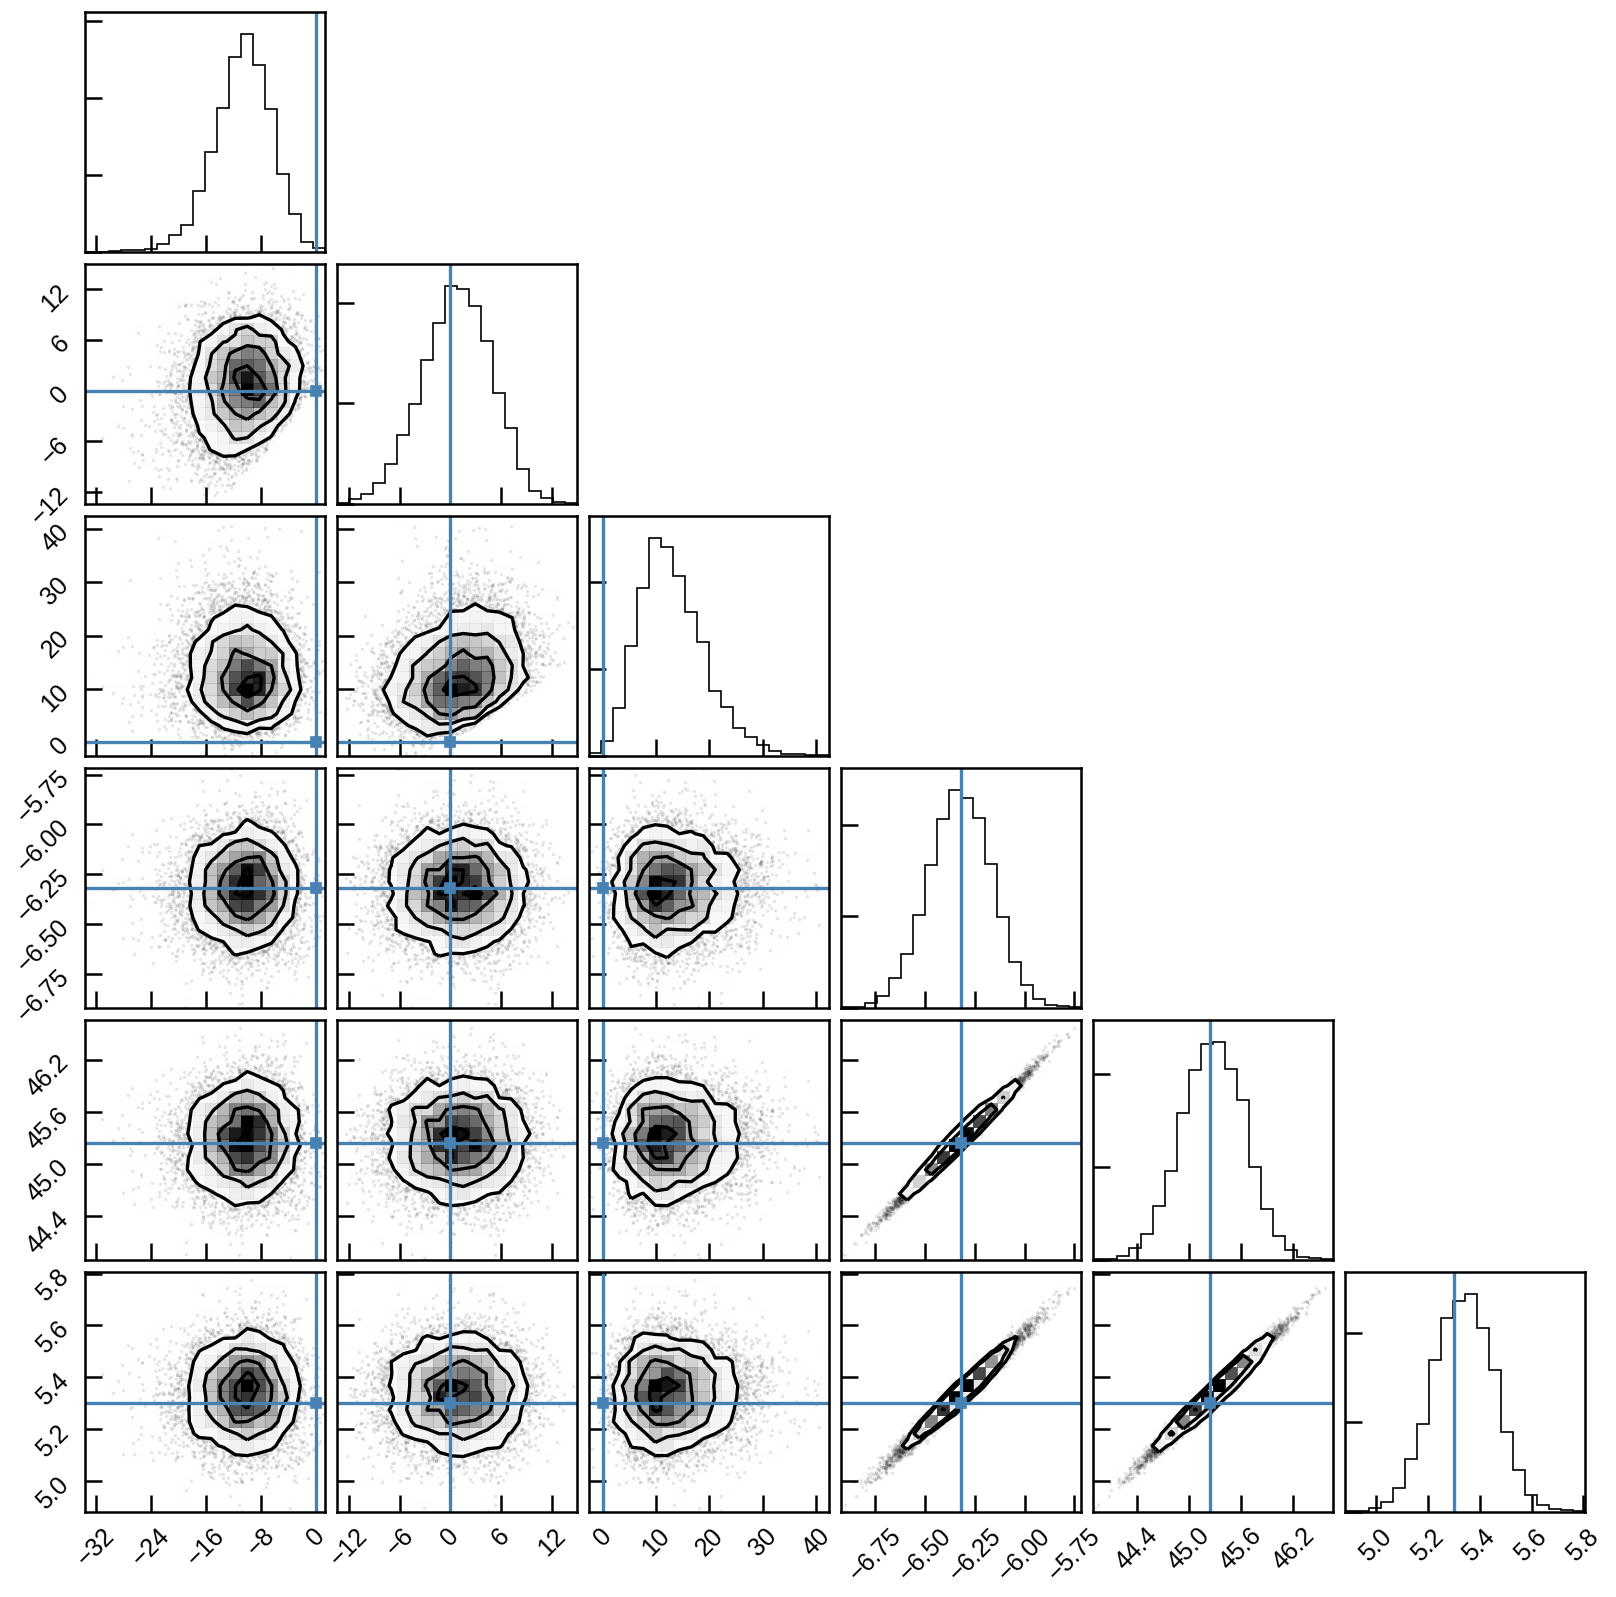

In [270]:
corner(np.vstack([sorted_w.T, stanfit['v0'].T]).T, truths=[0,0,0] + list(truth_T0['v0']));

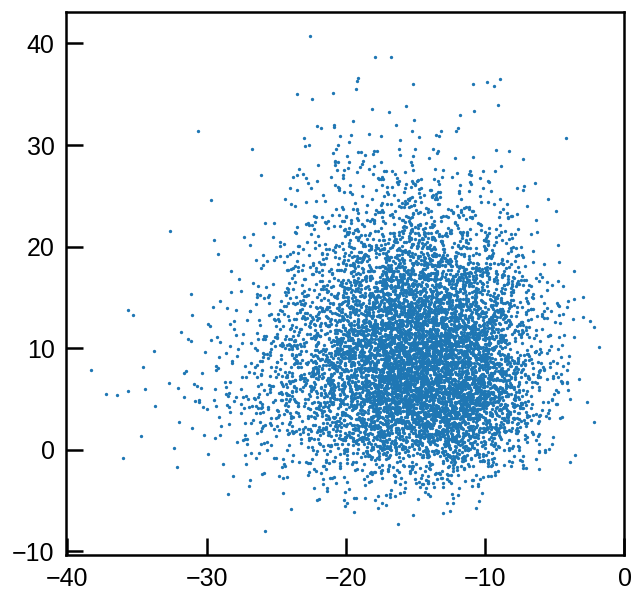

In [259]:
plt.scatter(sorted_w.T[0], sorted_w.T[2],s=1)

In [206]:
import scipy as sp

In [219]:
for k, v in case.items():
    if k.endswith("azfit"):
        print(k)
        print(az.summary(
            v,
            stat_funcs={"pos0": lambda x: sp.stats.percentileofscore(x, 0)},
            var_names=names,
        )[['mean','sd','pos0']])

T0_RV1_modelT0_0.azfit
          mean      sd    pos0
omegax  -1.571   9.649  56.850
omegay  -3.493   6.537  70.175
omegaz   7.343  11.571  25.550
w1       1.834   8.725  41.575
w2      -1.635   5.096  62.825
w3       5.753  13.901  34.650
w4      -6.349  10.907  72.950
w5     -13.767  12.299  86.050
kappa  -11.672   6.287  96.850
T0_RVa_modelT1_0.azfit
         mean     sd    pos0
omegax -5.519  4.709  87.712
omegay  0.724  3.667  42.212
omegaz  8.693  5.498   6.012
w1      4.591  4.296  14.550
w2      3.562  3.305  14.300
w3      5.580  6.241  18.362
w4     -2.474  5.722  66.812
w5     -7.928  6.623  88.588
kappa  -3.461  3.285  85.575
T0_RV1_modelT1_0.azfit
          mean      sd    pos0
omegax   7.715  10.048  22.312
omegay  -1.212   6.881  57.138
omegaz -11.803  12.292  83.688
w1      -1.085   9.291  55.000
w2      -4.548   5.364  79.950
w3      -2.048  14.756  55.400
w4     -18.268  12.483  92.825
w5      14.380  17.187  19.975
kappa   -7.874  10.316  77.675
T0_RV1_modelT1_1.azfi

In [220]:
azfit = case['T0_RV1_modelT1_2.azfit']

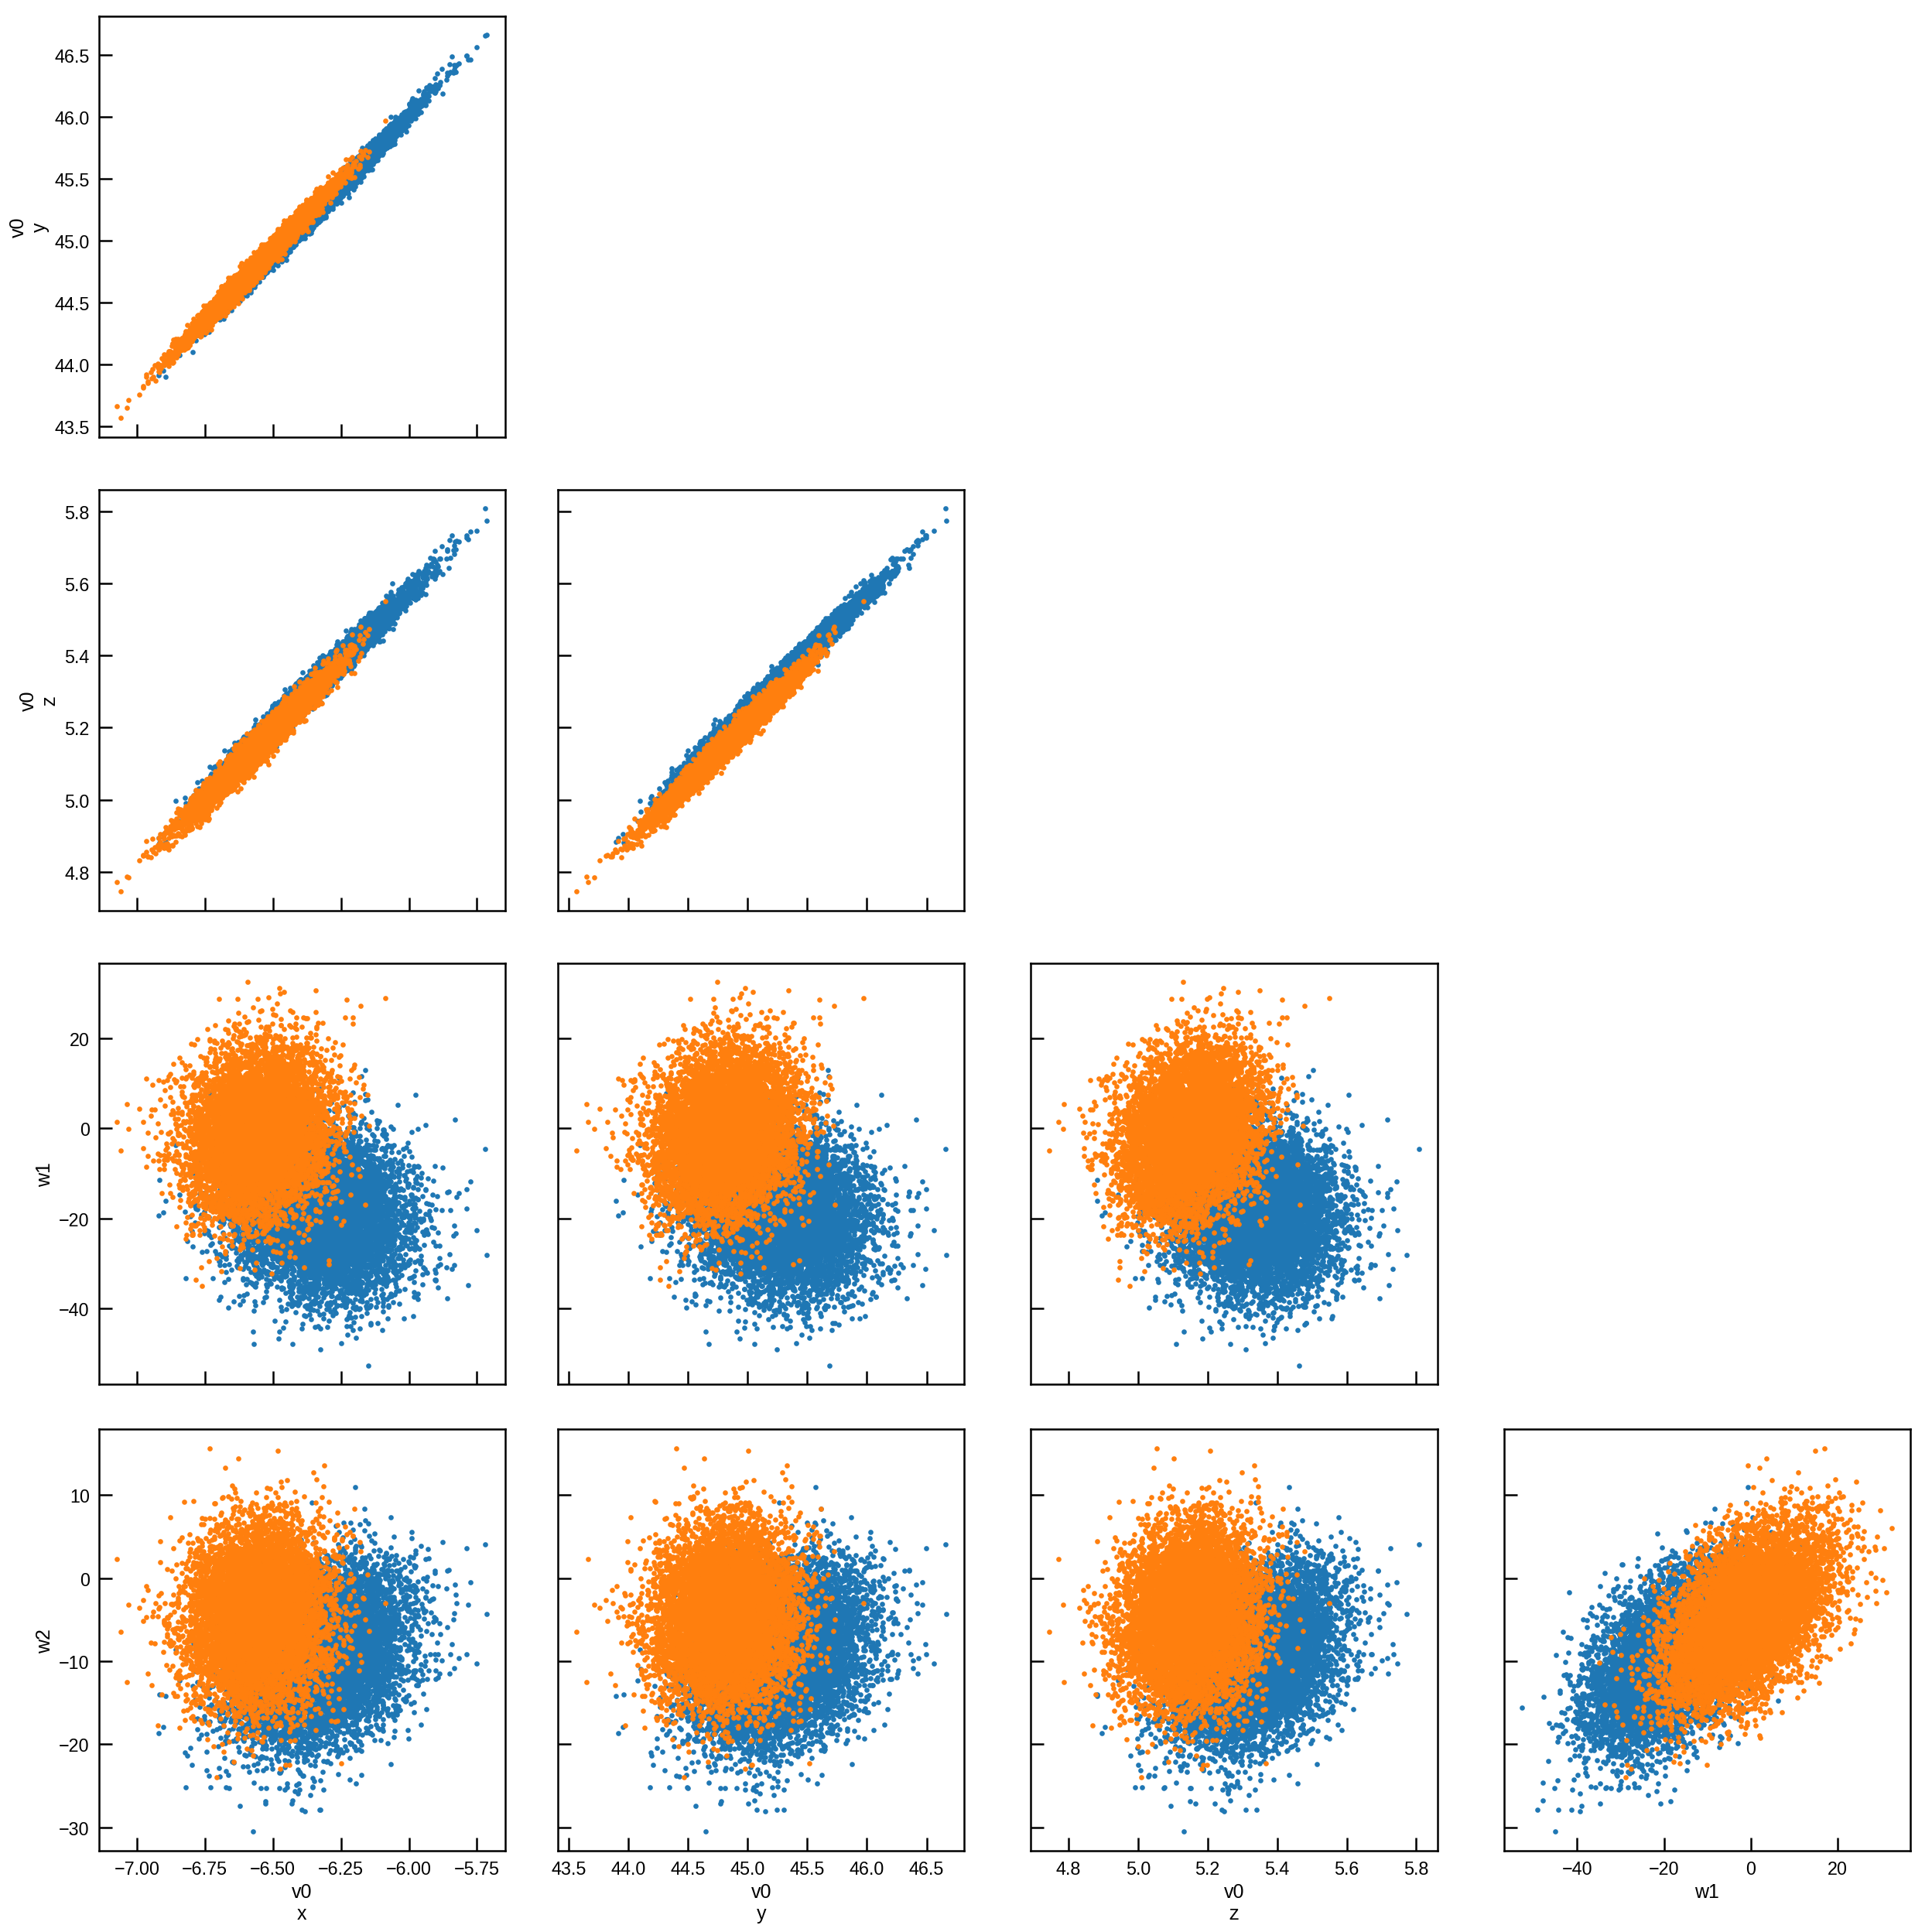

In [224]:
ax=az.plot_pair(azfit, ['v0','w1','w2'])
az.plot_pair(case['T0_RV1_modelT1_0.azfit'], ['v0','w1','w2'], ax=ax);

In [214]:
az.summary(
    azfit,
    stat_funcs={"pos0": lambda x: sp.stats.percentileofscore(x, 0)},
    var_names=names,
)

mean      sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
omegax   7.715  10.048 -11.004   26.416      0.190    0.135    2789.0  2789.0   
omegay  -1.212   6.881 -14.265   11.608      0.140    0.099    2401.0  2401.0   
omegaz -11.803  12.292 -32.990   13.063      0.211    0.149    3390.0  3390.0   
w1      -1.085   9.291 -18.212   16.949      0.153    0.108    3677.0  3677.0   
w2      -4.548   5.364 -14.381    5.586      0.077    0.055    4813.0  4813.0   
w3      -2.048  14.756 -29.387   25.626      0.313    0.221    2229.0  2229.0   
w4     -18.268  12.483 -42.255    4.096      0.270    0.191    2144.0  2144.0   
w5      14.380  17.187 -17.969   46.491      0.360    0.255    2273.0  2273.0   
kappa   -7.874  10.316 -28.570   10.387      0.239    0.169    1867.0  1867.0   

        ess_bulk  ess_tail  r_hat  pos0-rank  
omegax    2780.0    4169.0    1.0     22.312  
omegay    2399.0    3736.0    1.0     57.138  
omegaz    3386.0    4005.0    1.0     83.688  
w1        3683.0    4800.0    1.0     55.000  
w2        4824.0    5898.0    1.0     79.950  
w3        2233.0    4280.0    1.0     55.400  
w4        2149.0    3525.0    1.0     92.825  
w5        2276.0    3891.0    1.0     19.975  
kappa     1870.0    3034.0    1.0     77.675

In [204]:
az.summary(azfit, var_names=names)

mean      sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
omegax   7.715  10.048 -11.004   26.416      0.190    0.135    2789.0  2789.0   
omegay  -1.212   6.881 -14.265   11.608      0.140    0.099    2401.0  2401.0   
omegaz -11.803  12.292 -32.990   13.063      0.211    0.149    3390.0  3390.0   
w1      -1.085   9.291 -18.212   16.949      0.153    0.108    3677.0  3677.0   
w2      -4.548   5.364 -14.381    5.586      0.077    0.055    4813.0  4813.0   
w3      -2.048  14.756 -29.387   25.626      0.313    0.221    2229.0  2229.0   
w4     -18.268  12.483 -42.255    4.096      0.270    0.191    2144.0  2144.0   
w5      14.380  17.187 -17.969   46.491      0.360    0.255    2273.0  2273.0   
kappa   -7.874  10.316 -28.570   10.387      0.239    0.169    1867.0  1867.0   

        ess_bulk  ess_tail  r_hat  
omegax    2780.0    4169.0    1.0  
omegay    2399.0    3736.0    1.0  
omegaz    3386.0    4005.0    1.0  
w1        3683.0    4800.0    1.0  
w2        4824.0    5898.0    1.0  
w3        2233.0    4280.0    1.0  
w4        2149.0    3525.0    1.0  
w5        2276.0    3891.0    1.0  
kappa     1870.0    3034.0    1.0

In [ ]:
g = sns.FacetGrid(d, hue="g", aspect=15, height=.5, palette=pal)

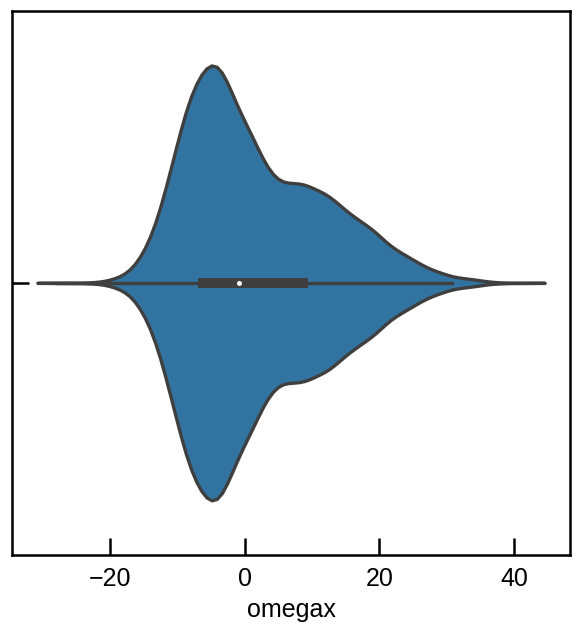

In [121]:
sns.violinplot(x='omegax', hue='group', orient='h', data=d, split=True);

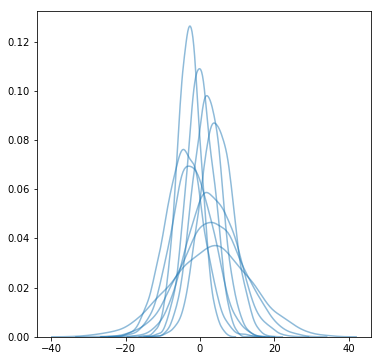

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for arr in azfit1.posterior.stack(sample=['chain','draw'], Ti=['T_param_dim_0', 'T_param_dim_1'])['T_param'].values.T:
    sns.distplot(
        arr,
        ax=ax,
        hist=False,
        color="tab:blue",
        kde_kws={"alpha": 0.5},
    )

In [ ]:
azfit1.posterior.stack(sample=['chain','draw'], Ti=['T_param_dim_0', 'T_param_dim_1']).transpose

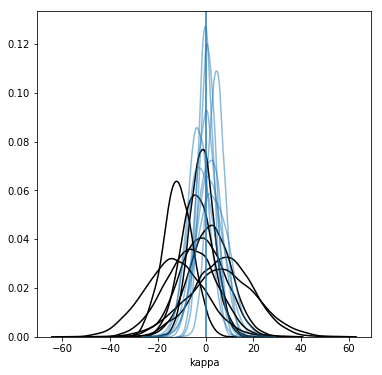

In [56]:
names = ["omegax", "omegay", "omegaz", "w1", "w2", "w3", "w4", "w5", "kappa"]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for n in names:
    sns.distplot(
        azfit.posterior.stack(sample=["chain", "draw"])[n], ax=ax, hist=False, color="k"
    )
    sns.distplot(
        azfit1.posterior.stack(sample=["chain", "draw"])[n],
        ax=ax,
        hist=False,
        color="tab:blue",
        kde_kws={"alpha": 0.5},
    )
ax.axvline(0, c="tab:blue")

In [177]:
from chainconsumer import ChainConsumer

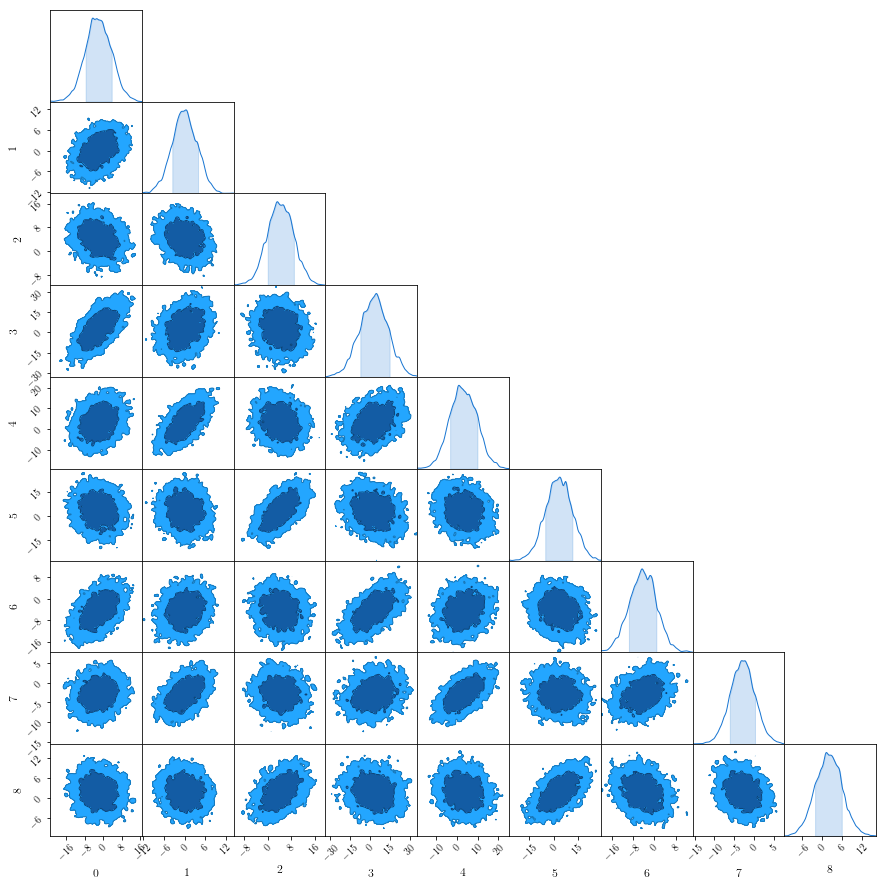

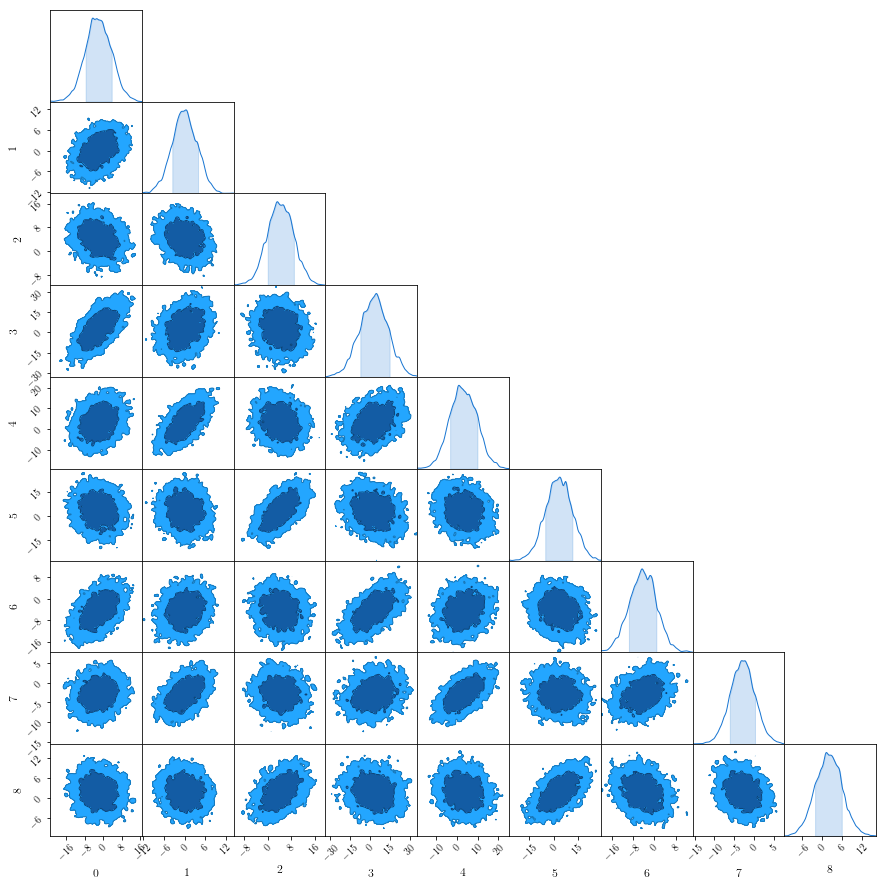

In [178]:
c = ChainConsumer()
c.add_chain(s, )
c.plotter.plot()

## Hipparcos-Gaia

In [6]:
hg = Table.read("/Users/semyeong/projects/data/brandt_hipparcos_gaia/HGCA_vDR2_corrected.fits").to_pandas()

merged = dr2hy[['source_id']]\
    .merge(hg, left_on='source_id', right_on='gaia_source_id')
print(len(merged), len(dr2hy))

116 515


In [7]:
hghy = merged.loc[:, merged.columns.str.contains('hg')].copy()\
    .rename(columns=lambda x: x.strip('_hg').replace('_hg_', '_'))\
    .rename(columns={'pmra_pmdec': 'pmra_pmdec_corr'})
hghy['ra'] = merged['gaia_ra']
hghy['dec'] = merged['gaia_dec']
hghy['parallax'] = merged['parallax_gaia']
hghy['parallax_error'] = merged['parallax_gaia_error']
hghy['radial_velocity'] = merged['radial_velocity']
hghy['radial_velocity_error'] = merged['radial_velocity_error']
hghy['parallax_pmra_corr'] = 0.
hghy['parallax_pmdec_corr'] = 0.

In [8]:
df = hghy[[
    'ra', 'dec', 'parallax', 'pmra', 'pmdec',
    'parallax_error', 'pmra_error', 'pmdec_error',
    'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
    'radial_velocity', 'radial_velocity_error'
]]
N = len(df)
ra, dec, a = df['ra'].values, df['dec'].values, df[['parallax', 'pmra', 'pmdec']].values
C = df.g.make_cov()

irv = np.where(df['radial_velocity'].notna().values)[0]
rv, rv_error = df['radial_velocity'].values[irv], df['radial_velocity_error'].values[irv]

b0 = df.g.icrs.cartesian.xyz.mean(axis=1)

In [15]:
v0 = np.nanmean(v0, axis=1)

In [16]:
Nrv = len(irv)
# irv = np.arange(len(rv))

def init():
    return dict(
        d=1e3/df.parallax.values,
        sigv=0.11,
        v0=v0,
#         T=np.empty(shape=(0,3,3))
        T=np.zeros(shape=(1,3,3))
    )

r = model.optimizing(
    data=dict(
        N=N, ra=ra, dec=dec, a=a, C=C,
        Nrv=Nrv, rv=rv, rv_error=rv_error, irv=irv,
        include_T=1, b0=b0.value
    ),
    init=init,)

In [17]:
r['v0'], r['sigv'],  r['T'], r['T_param']

(array([-6.20987187, 45.68440943,  5.51671358]),
 array(0.38935594),
 array([[[-0.00996049,  0.00963519,  0.01708738],
         [-0.08628262,  0.00816378,  0.05557362],
         [-0.00283629,  0.02043369,  0.00692506]]]),
 array([[-0.00996049,  0.00963519,  0.01708738],
        [-0.08628262,  0.00816378,  0.05557362],
        [-0.00283629,  0.02043369,  0.00692506]]))

In [18]:
omegax = 0.5*(r['T_param'][2, 1] - r['T_param'][1, 2])
omegay = 0.5*(r['T_param'][0, 2] - r['T_param'][2, 0])
omegaz = 0.5*(r['T_param'][1, 0] - r['T_param'][0, 1])

w1 = 0.5*(r['T_param'][2, 1] + r['T_param'][1, 2])
w2 = 0.5*(r['T_param'][0, 2] + r['T_param'][2, 0])
w3 = 0.5*(r['T_param'][1, 0] + r['T_param'][0, 1])
w4 = r['T_param'][0, 0]
w5 = r['T_param'][1, 1]
print(omegax, omegay, omegaz)
print(w1, w2, w3)
print(w4, w5)

-0.017569964818304307 0.009961833656229284 -0.0479589084597497
0.03800365263510913 0.007125548011004805 -0.038323713524761334
-0.009960493806043422 0.008163781076794299


In [19]:
%%time
ra, dec, a = df['ra'].values, df['dec'].values, df[['parallax', 'pmra', 'pmdec']].values
C = df.g.make_cov()
irv = np.where(df['radial_velocity'].notna().values)[0]
rv, rv_error = df['radial_velocity'].values[irv], df['radial_velocity_error'].values[irv]
Nrv = len(irv)

def init():
    return dict(
        d=1e3/df.parallax.values,
        sigv=0.11,
        v0=v0,
#         T=np.empty(shape=(0,3,3))
        T=np.zeros(shape=(1,3,3))
    )

rs = model.sampling(
    data=dict(
        N=N, ra=ra, dec=dec, a=a, C=C,
        Nrv=Nrv, rv=rv, rv_error=rv_error, irv=irv,
        include_T=1, b0=b0.value
    ),
    init=init,)

CPU times: user 7.07 s, sys: 295 ms, total: 7.37 s
Wall time: 2min 9s


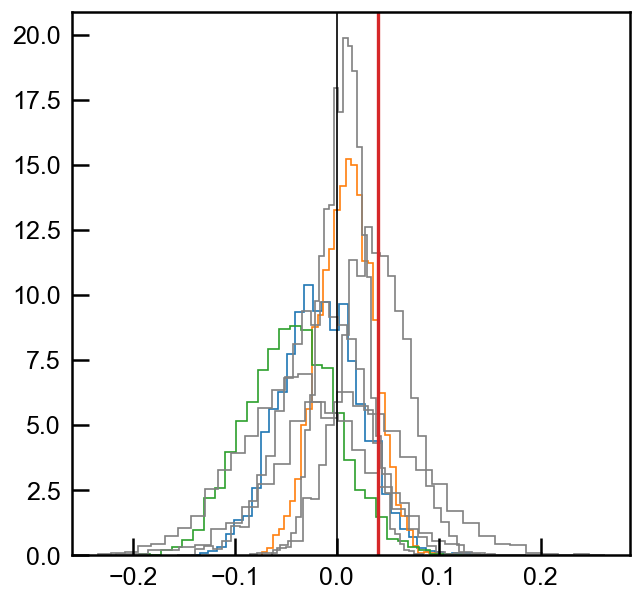

In [20]:
omegax = 0.5*(rs['T_param'][:, 2, 1] - rs['T_param'][:, 1, 2])
omegay = 0.5*(rs['T_param'][:, 0, 2] - rs['T_param'][:, 2, 0])
omegaz = 0.5*(rs['T_param'][:, 1, 0] - rs['T_param'][:, 0, 1])

w4 = rs['T_param'][:, 0, 0]
w5 = rs['T_param'][:, 1, 1]

w1 = 0.5*(rs['T_param'][:, 2, 1] + rs['T_param'][:, 1, 2])
w2 = 0.5*(rs['T_param'][:, 0, 2] + rs['T_param'][:, 2, 0])
w3 = 0.5*(rs['T_param'][:, 1, 0] + rs['T_param'][:, 0, 1])

k = (rs['T_param'][:, 2, 2] + w4 + w5)/3.

plt.hist(omegax, 32, histtype='step', density=True);
plt.hist(omegay, 32, histtype='step', density=True);
plt.hist(omegaz, 32, histtype='step', density=True);


for cw in [w1, w2, w3, w4, w5]:
    plt.hist(cw, 32, histtype='step', color='gray', density=True)
plt.axvline(0, c='k', lw=1);
plt.axvline(40/1e3, c='tab:red')

In [21]:
aa = pd.DataFrame(dict(omegax=omegax, omegay=omegay, omegaz=omegaz,
              w1=w1, w2=w2, w3=w3, w4=w4, w5=w5, k=k))

In [22]:
np.abs(aa.mean()) / aa.std()

omegax    0.415060
omegay    0.347633
omegaz    0.982935
w1        1.139703
w2        0.356042
w3        0.593397
w4        0.275324
w5        0.185942
k         0.077349
dtype: float64

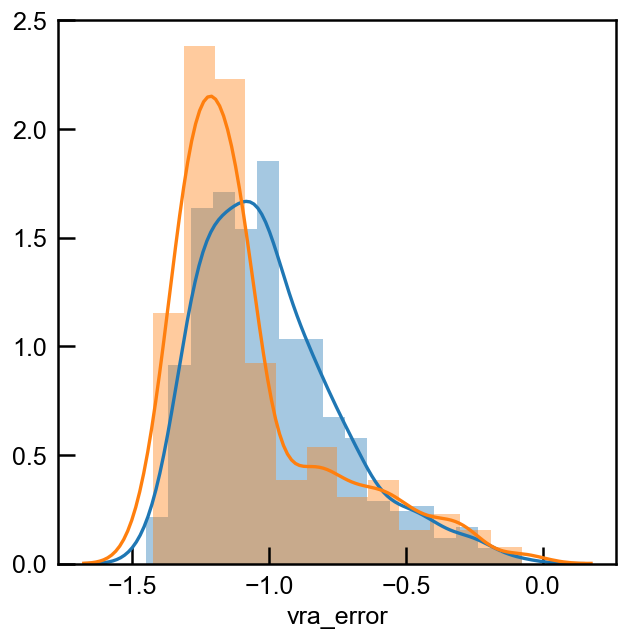

In [40]:
sns.distplot(np.log10(dr2hy.pipe(gp.add_vtan_errors)['vra_error']), )
sns.distplot(np.log10(hghy.pipe(gp.add_vtan_errors)['vra_error']))
plt.xlabel('vra_error');

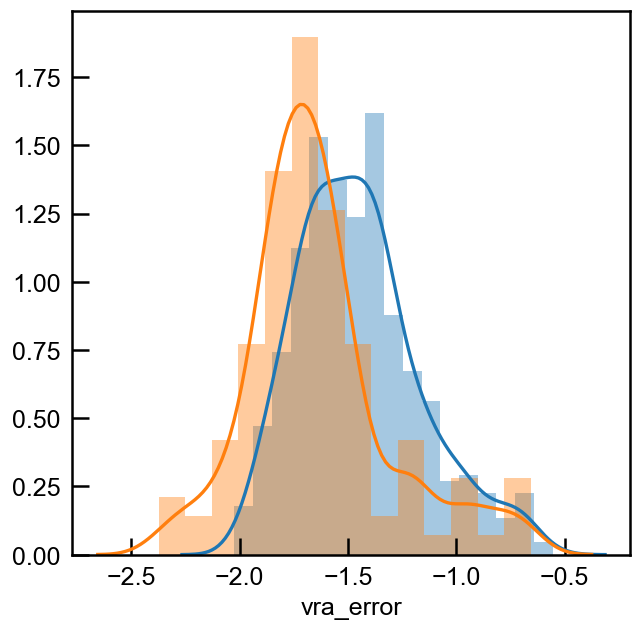

In [41]:
sns.distplot(np.log10(dr2hy.pipe(gp.add_vtan_errors)['vdec_error']), )
sns.distplot(np.log10(hghy.pipe(gp.add_vtan_errors)['vdec_error']))
plt.xlabel('vra_error');

In [31]:
aa.std()

omegax    0.038712
omegay    0.026353
omegaz    0.044697
w1        0.032252
w2        0.020460
w3        0.060296
w4        0.040837
w5        0.065978
k         0.030345
dtype: float64

In [25]:
import seaborn as sns

In [44]:
rs['sigv']

array([0.43231491, 0.42240121, 0.42196544, ..., 0.40205825, 0.4137065 ,
       0.41765261])

In [49]:
np.mean(rs['sigv']), np.std(rs['sigv'])

(0.4148692412083114, 0.021357458335487793)

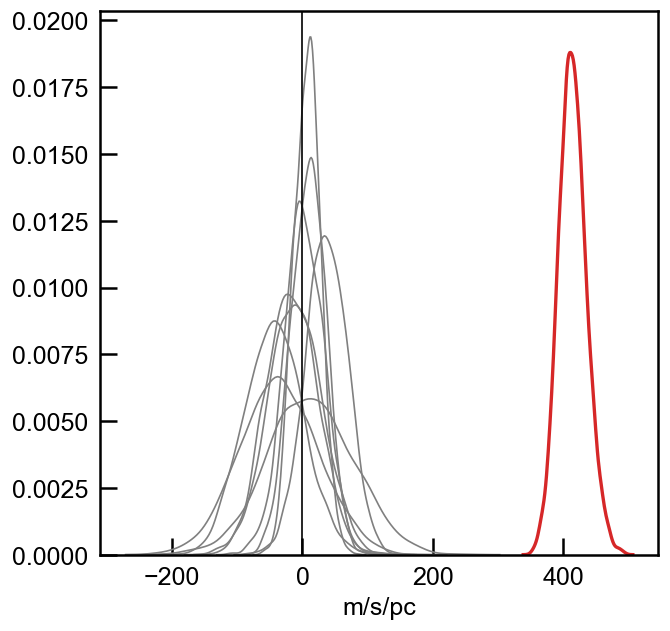

In [46]:
for col in aa.columns:
    sns.distplot(aa[col] * 1e3, hist=False, kde_kws={'color':'gray', 'lw':1})
plt.axvline(0, c='k', lw=1);
plt.xlabel('m/s/pc');
sns.distplot(rs['sigv'] * 1e3, hist=False, kde_kws={'color':'tab:red', 'lw':2})

In [ ]:
from corner import corner

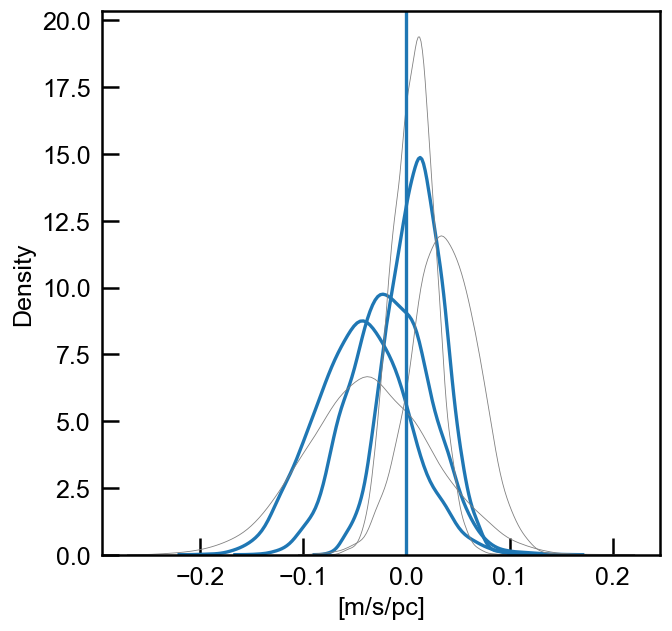

In [27]:
for pp in [aa]:
    omegax, omegay, omegaz, w1, w2, w3, w4, w5, k = pp.values.T
    plt.figure()
#     plt.axvline(40, lw=1, c='gray')
#     plt.axvline(0, lw=1, c='gray')

    sns.distplot(omegax, hist=False, kde_kws={'color':'tab:blue'})
    sns.distplot(omegay, hist=False, kde_kws={'color':'tab:blue'})
    sns.distplot(omegaz, hist=False, kde_kws={'color':'tab:blue'})

    for cw in [w1, w2, w3]:#, w4, w5, k]:
        sns.distplot(cw, hist=False, color='gray', kde_kws={'lw':.5})

plt.xlabel('[m/s/pc]')
plt.ylabel('Density');
plt.axvline(0)

In [52]:
import astropy.constants as c

In [47]:
from corner import corner

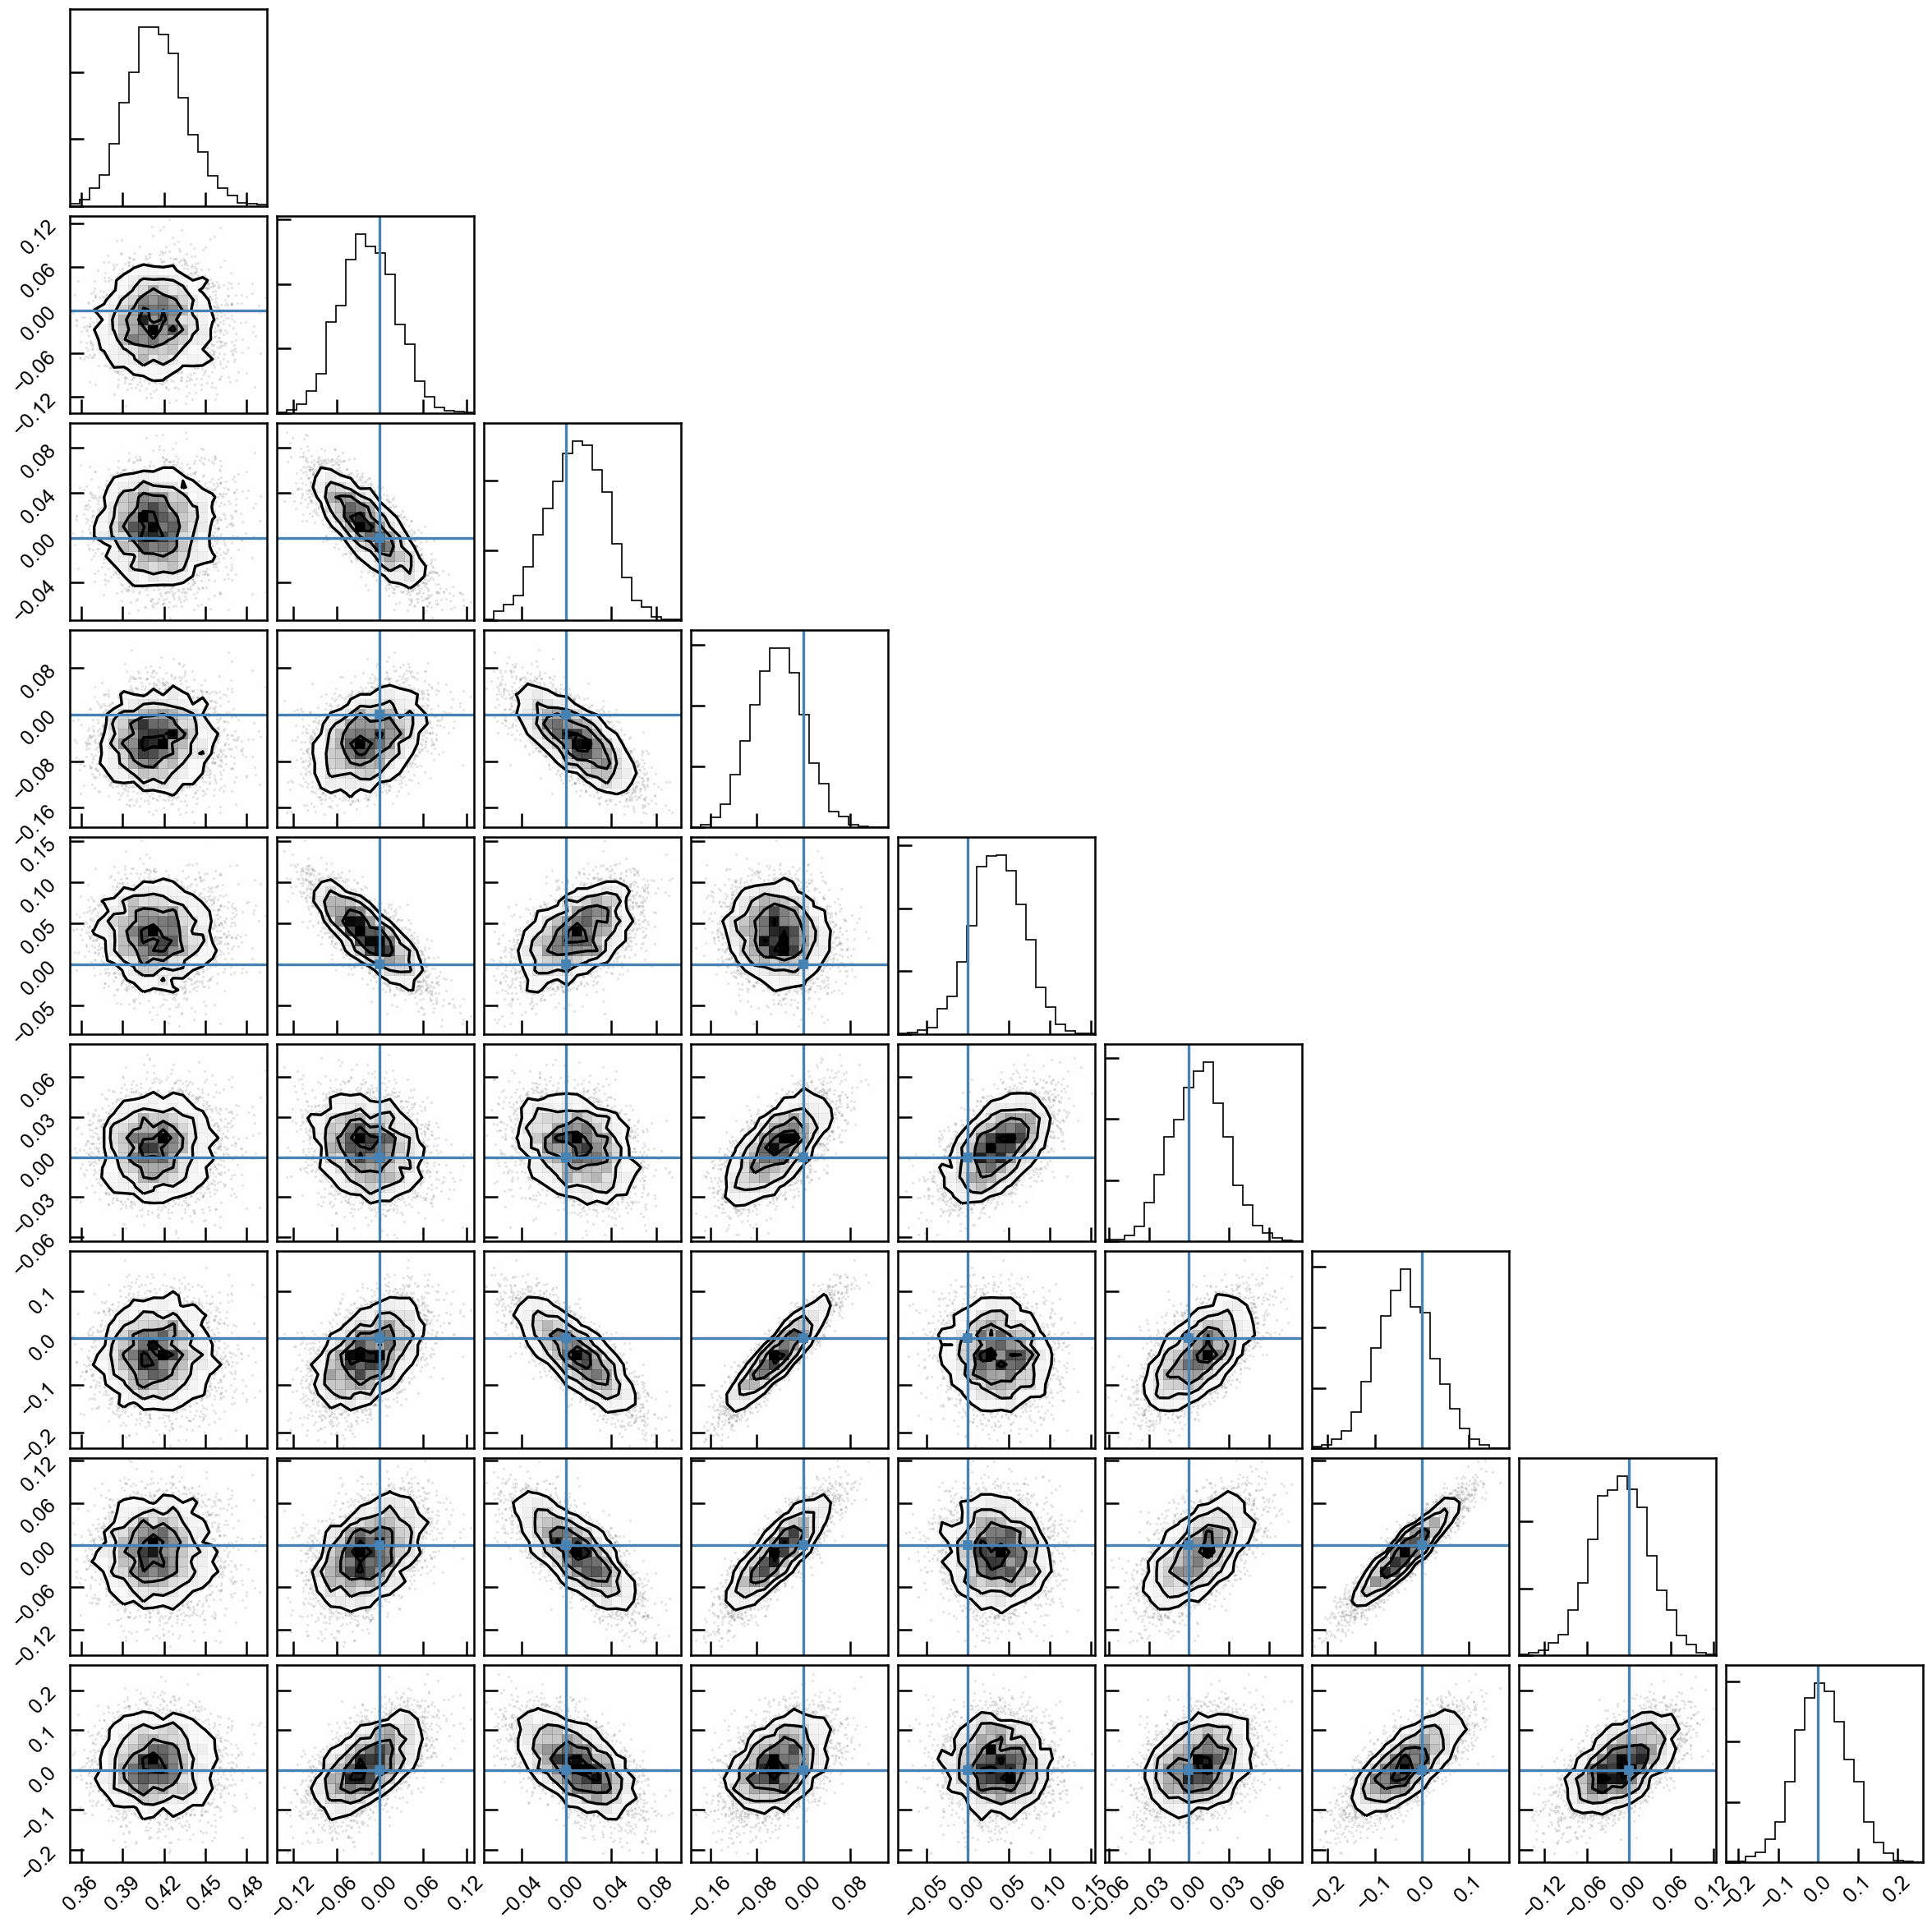

In [48]:
truths = [0.3, 0, 0, 0, 0, 0, 0, 0, 0]
fig = corner(np.vstack([rs['sigv'], omegax, omegay, omegaz, w1, w2, w3, w4, w5]).T,
             truths=truths)

* Test with mock data increasing N (sqrt(N) benefit) vs higher precision